# Imports

In [301]:
import numpy as np
import pandas as pd
import math
from functools import reduce

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
color = sns.color_palette()
sns.set_style('darkgrid')

df = pd.read_csv("data/AmesHousing.csv")

In [302]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.metrics import mean_absolute_error

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

from sklearn import set_config
set_config(display="diagram")

# Split

In [303]:
raise BaseException("You might not want to change the current data split, run from 'Feature Engineering' if you want to keep the current split")

BaseException: You might not want to change the current data split, run from 'Feature Engineering' if you want to keep the current split

In [ ]:
# Remove useless columns and columns with too much missing value
df = df.drop(['Order', 'PID', 'Alley', 'Fence', 'Misc Feature'], axis=1)
df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)

In [ ]:
df_train.reset_index().to_feather("data/df_train.feather")
df_test.reset_index().to_feather("data/df_test.feather")

# Feature engineering

In [304]:
df_train = pd.read_feather("data/df_train.feather").drop("index", axis=1)
df_test = pd.read_feather("data/df_test.feather").drop("index", axis=1)

In [305]:
df_train.columns

Index(['MS SubClass', 'MS Zoning', 'Lot Frontage', 'Lot Area', 'Street',
       'Lot Shape', 'Land Contour', 'Utilities', 'Lot Config', 'Land Slope',
       'Neighborhood', 'Condition 1', 'Condition 2', 'Bldg Type',
       'House Style', 'Overall Qual', 'Overall Cond', 'Year Built',
       'Year Remod/Add', 'Roof Style', 'Roof Matl', 'Exterior 1st',
       'Exterior 2nd', 'Mas Vnr Type', 'Mas Vnr Area', 'Exter Qual',
       'Exter Cond', 'Foundation', 'Bsmt Qual', 'Bsmt Cond', 'Bsmt Exposure',
       'BsmtFin Type 1', 'BsmtFin SF 1', 'BsmtFin Type 2', 'BsmtFin SF 2',
       'Bsmt Unf SF', 'Total Bsmt SF', 'Heating', 'Heating QC', 'Central Air',
       'Electrical', '1st Flr SF', '2nd Flr SF', 'Low Qual Fin SF',
       'Gr Liv Area', 'Bsmt Full Bath', 'Bsmt Half Bath', 'Full Bath',
       'Half Bath', 'Bedroom AbvGr', 'Kitchen AbvGr', 'Kitchen Qual',
       'TotRms AbvGrd', 'Functional', 'Fireplaces', 'Fireplace Qu',
       'Garage Type', 'Garage Yr Blt', 'Garage Finish', 'Garage Cars',

In [306]:
categorical_features = ['MS SubClass', 'MS Zoning',
        'Street', 'Lot Shape', 'Land Contour', 'Utilities',
        'Lot Config', 'Land Slope', 'Neighborhood', 'Condition 1',
        'Condition 2', 'Bldg Type', 'House Style', 'Overall Qual',
        'Overall Cond', 'Roof Style',
        'Roof Matl', 'Exterior 1st', 'Exterior 2nd', 
        'Mas Vnr Type', 'Exter Qual',
        'Exter Cond', 'Foundation', 'Bsmt Qual', 'Bsmt Cond', 'Bsmt Exposure',
        'BsmtFin Type 1',  'BsmtFin Type 2', 
        'Heating', 'Heating QC', 'Central Air',
        'Electrical',  'Bsmt Full Bath', 'Bsmt Half Bath', 'Full Bath',
        'Half Bath', 'Bedroom AbvGr', 'Kitchen AbvGr', 'Kitchen Qual',
        'TotRms AbvGrd', 'Functional', 'Fireplaces' , 'Garage Type',
        'Garage Finish', 'Garage Cars', 
        'Garage Qual', 'Garage Cond', 'Paved Drive', 'Mo Sold', 'Sale Type',
        'Sale Condition', 'Fireplace Qu', 'Pool QC', 'Yr Sold'] # 'Alley', 'Fence', 'Misc Feature' 

numerical_features = ['Lot Frontage', 'Lot Area','Year Built','Year Remod/Add', 'Mas Vnr Area','BsmtFin SF 1','BsmtFin SF 2','Bsmt Unf SF',
        'Total Bsmt SF','1st Flr SF', '2nd Flr SF', 'Low Qual Fin SF',
        'Gr Liv Area','Garage Yr Blt', 'Garage Area','Wood Deck SF',
        'Open Porch SF', 'Enclosed Porch', '3Ssn Porch', 'Screen Porch',
        'Pool Area', 'Misc Val']

In [307]:
def mae(model, X_train, y_train, X_test, y_test):
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)

    train_mae = mean_absolute_error(y_train, y_pred_train)
    test_mae = mean_absolute_error(y_test, y_pred_test)

    print('MAE on train data: ', train_mae)
    print('MAE on test data: ',  test_mae)
    return train_mae, test_mae

def compare_to_base(train_mae, test_mae):
    print("Difference with base train: ", train_mae - base_train_mae)
    print("Difference with base test: ", test_mae - base_test_mae)

## Baseline

In [308]:
X_train = df_train.drop("SalePrice", axis=1)
y_train = df_train["SalePrice"]

X_test = df_test.drop("SalePrice", axis=1)
y_test = df_test["SalePrice"]

In [309]:
import json
with open("baseline.json", "r") as f:
    baseline = json.load(f)
    base_train_mae = baseline["mae_train"]
    base_test_mae = baseline["mae_test"]

## Improving it

### Improve the pipeline and handle the ordinal values

#### Create and train new pipeline

In [310]:
# for col in df_train.columns:
#     print(f"{col}({df_train[col].nunique(dropna=False)}): {df_train[col].unique()[0:8]}")

In [311]:
categorical_features = ['MS SubClass', 'MS Zoning',
        'Street', 'Lot Shape', 'Land Contour', 'Utilities',
        'Lot Config', 'Land Slope', 'Neighborhood', 'Condition 1',
        'Condition 2', 'Bldg Type', 'House Style', 'Overall Qual',
        'Overall Cond', 'Roof Style',
        'Roof Matl', 'Exterior 1st', 'Exterior 2nd', 
        'Mas Vnr Type', 'Exter Qual',
        'Exter Cond', 'Foundation', 'Bsmt Qual', 'Bsmt Cond', 'Bsmt Exposure',
        'BsmtFin Type 1',  'BsmtFin Type 2', 
        'Heating', 'Heating QC', 'Central Air',
        'Electrical',  'Bsmt Full Bath', 'Bsmt Half Bath', 'Full Bath',
        'Half Bath', 'Bedroom AbvGr', 'Kitchen AbvGr', 'Kitchen Qual',
        'TotRms AbvGrd', 'Functional', 'Fireplaces' , 'Garage Type',
        'Garage Finish', 'Garage Cars', 
        'Garage Qual', 'Paved Drive', 'Mo Sold', 'Sale Type',
        'Sale Condition', 'Fireplace Qu', 'Pool QC', 'Garage Cond', 'Yr Sold'
        ] # 'Alley', 'Fence', 'Misc Feature'

numerical_features = ['Lot Frontage', 'Lot Area', 'Mas Vnr Area','BsmtFin SF 1','BsmtFin SF 2','Bsmt Unf SF',
        'Total Bsmt SF','1st Flr SF', '2nd Flr SF', 'Low Qual Fin SF',
        'Gr Liv Area', 'Garage Area','Wood Deck SF',
        'Open Porch SF', 'Enclosed Porch', '3Ssn Porch', 'Screen Porch',
        'Pool Area', 'Misc Val', 'Garage Yr Blt', 'Year Built', 'Year Remod/Add']

ordinal_features = ['Lot Shape', 'Utilities', 'Land Slope',  'Overall Qual', 'Overall Cond',
                'Exter Qual', 'Exter Cond', 'Bsmt Qual', 'Bsmt Cond', 'Bsmt Exposure', 'BsmtFin Type 1', 
                'BsmtFin Type 2', 'Heating QC', 'Kitchen Qual', 'Functional', 'Fireplace Qu', 'Garage Finish',
                'Garage Qual', 'Garage Cond', 'Pool QC', 'Yr Sold', 'Garage Yr Blt', 'Year Built', 'Year Remod/Add']

In [312]:
print(len(categorical_features), len(numerical_features), len(ordinal_features))
ordinal_features = [feat for feat in ordinal_features if feat in categorical_features or feat in numerical_features]
categorical_features = [feat for feat in categorical_features if feat not in ordinal_features]
numerical_features = [feat for feat in numerical_features if feat not in ordinal_features]
print(len(categorical_features), len(numerical_features), len(ordinal_features))

54 22 24
33 19 24


In [313]:
numerical_transformer = SimpleImputer()
categorical_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

ordinal_encoding= ColumnTransformer(
    transformers=[
        ("other", OrdinalEncoder(categories=[
            ["Reg", "IR1", "IR2", "IR3"],
            ["ELO", "NoSeWa", "NoSewr", "AllPub"],
            ["Gtl", "Mod", "Sev"],
            [None, "No", "Mn", "Av", "Gd"],
            [None, "Unf", "LwQ", "Rec", "BLQ", "ALQ", "GLQ"],
            [None, "Unf", "LwQ", "Rec", "BLQ", "ALQ", "GLQ"],
            ["Sal", "Sev", "Maj2", "Maj1", "Mod", "Min2", "Min1", "Typ"],
            [None, "Unf", "RFn", "Fin"]
        ]), ["Lot Shape", "Utilities", "Land Slope", "Bsmt Exposure", 'BsmtFin Type 1', 'BsmtFin Type 2', "Functional", "Garage Finish"]),

        ("qual_cond_nan", OrdinalEncoder(categories=
        [["Po", None, "Fa", "TA", "Gd", "Ex"] for _ in range(6)]),
        ['Bsmt Qual', 'Bsmt Cond', 'Fireplace Qu', 'Garage Qual', 'Pool QC', 'Garage Cond']
        ),

        ("qual_cond", OrdinalEncoder(categories=
        [["Po", "Fa", "TA", "Gd", "Ex"] for _ in range(4)]),
        ['Exter Qual', 'Exter Cond', 'Heating QC', 'Kitchen Qual']),

    ],
    remainder="passthrough" # Overall Qual/Cond, 'Yr Sold', 'Garage Yr Blt', 'Year Built', 'Year Remod/Add'
)

ordinal_transformer = Pipeline([
    ("ord_encoding", ordinal_encoding),
    ("imputing", SimpleImputer())
])

In [314]:
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numerical_transformer, numerical_features),
        ("cat", categorical_transformer, categorical_features),
        ("ord", ordinal_transformer, ordinal_features)
    ],
    remainder="drop"
)

inference_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("model", LinearRegression())
])

inference_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', SimpleImputer(),
                                                  ['Lot Frontage', 'Lot Area',
                                                   'Mas Vnr Area',
                                                   'BsmtFin SF 1',
                                                   'BsmtFin SF 2',
                                                   'Bsmt Unf SF',
                                                   'Total Bsmt SF',
                                                   '1st Flr SF', '2nd Flr SF',
                                                   'Low Qual Fin SF',
                                                   'Gr Liv Area', 'Garage Area',
                                                   'Wood Deck SF',
                                                   'Open Porch SF',
                                                   'Enclosed Porch',
                                                   '3Ssn Porch', 'Screen Porch',
                                                   'Pool Area', 'Misc Val']),
                                                 ('cat',
                                                  Pipeline(ste...
                                                                   SimpleImputer())]),
                                                  ['Lot Shape', 'Utilities',
                                                   'Land Slope', 'Overall Qual',
                                                   'Overall Cond', 'Exter Qual',
                                                   'Exter Cond', 'Bsmt Qual',
                                                   'Bsmt Cond', 'Bsmt Exposure',
                                                   'BsmtFin Type 1',
                                                   'BsmtFin Type 2',
                                                   'Heating QC', 'Kitchen Qual',
                                                   'Functional', 'Fireplace Qu',
                                                   'Garage Finish',
                                                   'Garage Qual', 'Garage Cond',
                                                   'Pool QC', 'Yr Sold',
                                                   'Garage Yr Blt',
                                                   'Year Built',
                                                   'Year Remod/Add'])])),
                ('model', LinearRegression())])

#### Evaluate and plot results

In [315]:
compare_to_base(*mae(inference_pipeline, X_train, y_train, X_test, y_test))

MAE on train data:  15642.562978243239
MAE on test data:  18210.58781434211
Difference with base train:  -4646.769936207651
Difference with base test:  -3114.328679628303


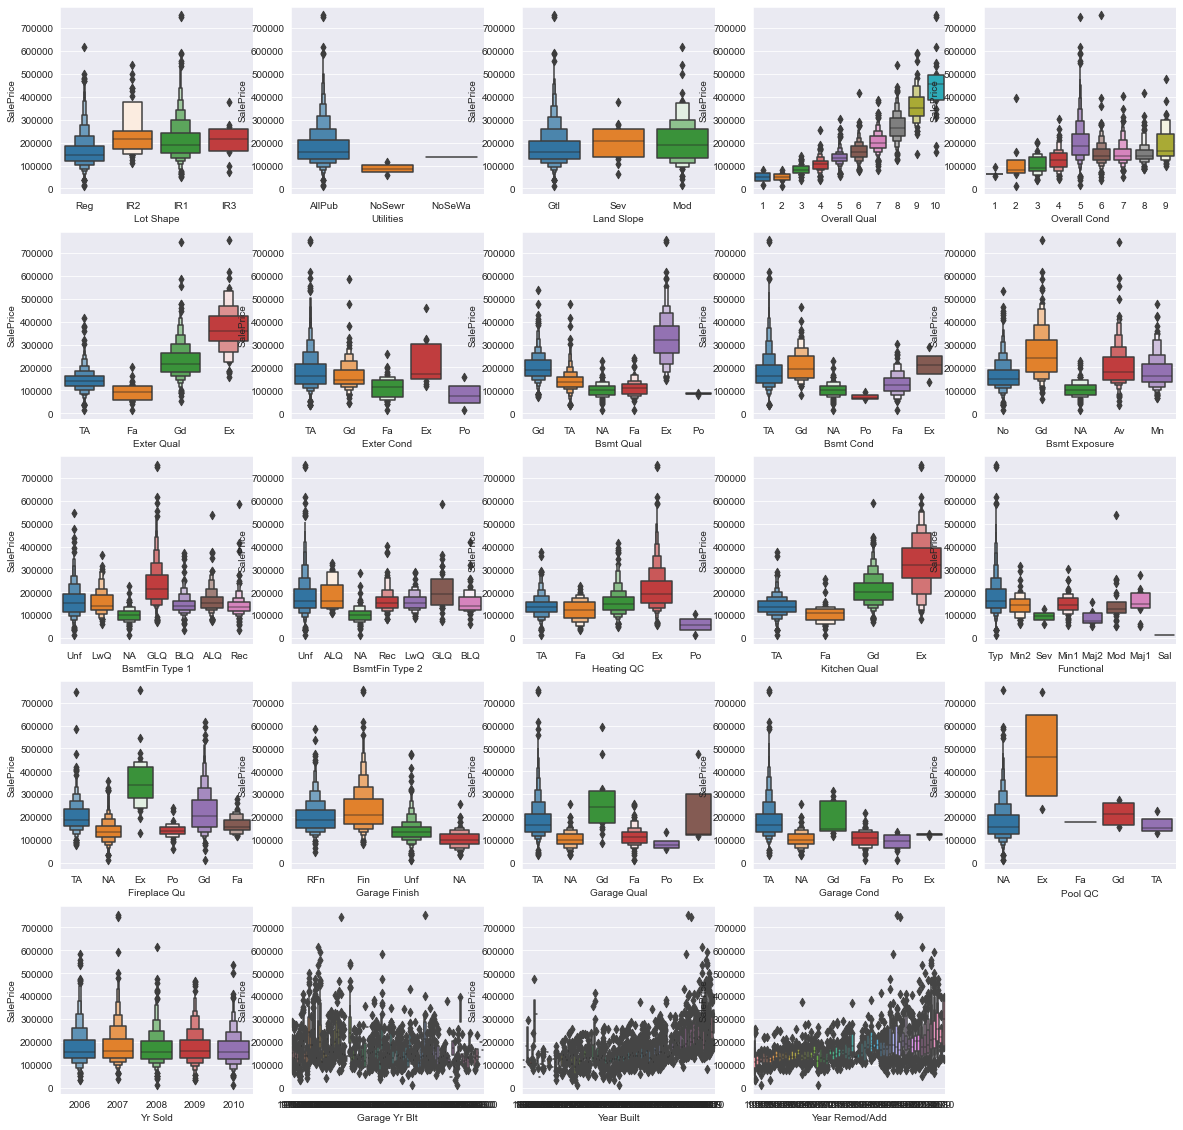

In [316]:
plt.figure(figsize=(20,20))
for i, col in enumerate(ordinal_features):
    ax = plt.subplot(math.ceil(len(ordinal_features) / 5), 5, i+1)
    sns.boxenplot(x=X_train[col].fillna("NA"), y=y_train, ax=ax)

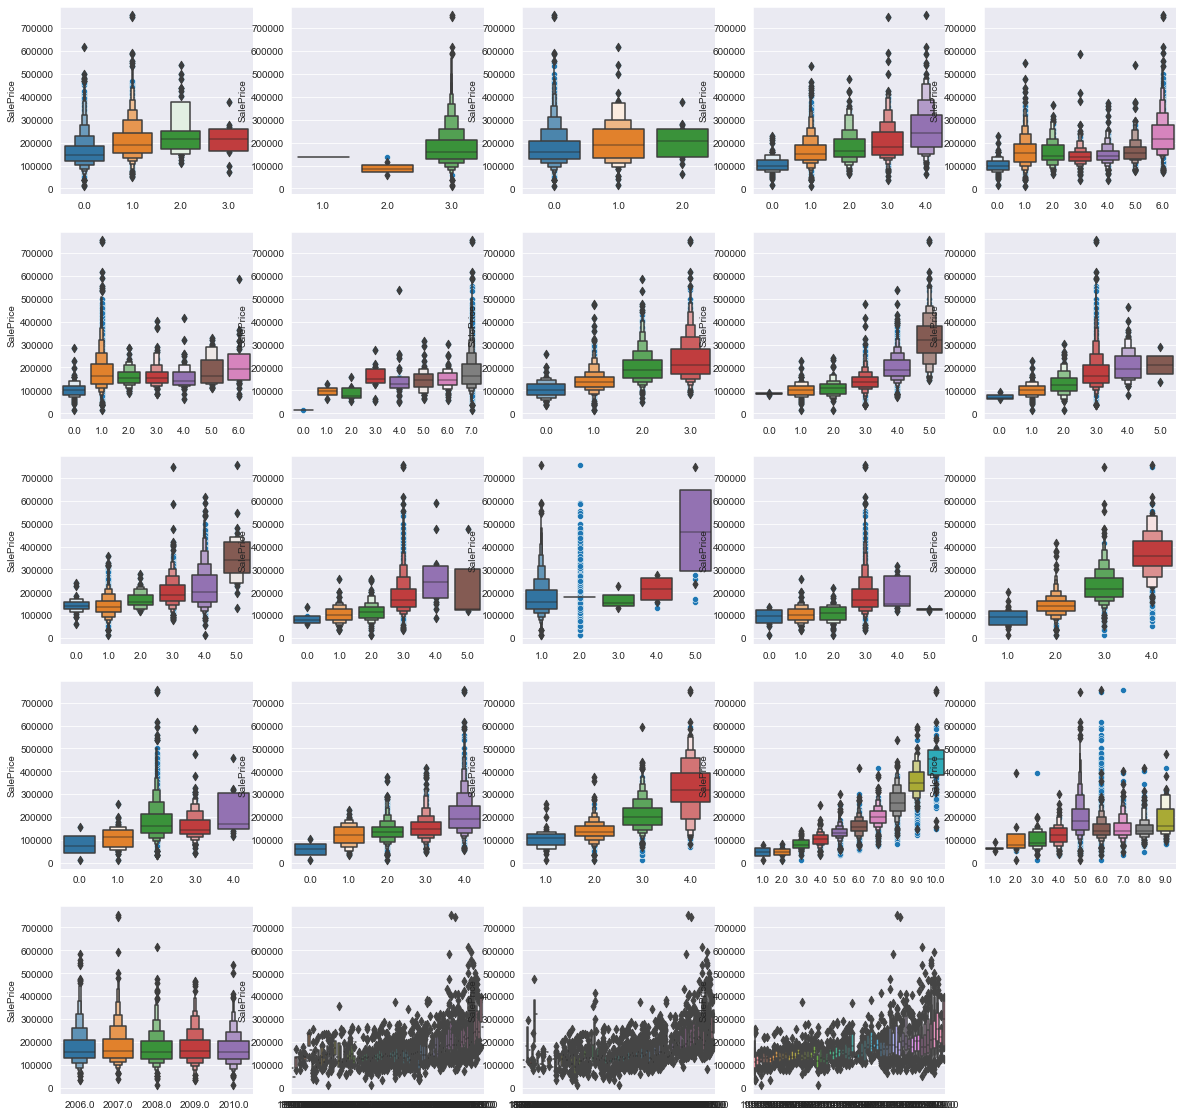

In [317]:
preprocessor = ColumnTransformer(
    transformers=[
        ("ord", ordinal_transformer, ordinal_features)
    ],
    remainder="drop"
)
test_data = preprocessor.fit_transform(X_train)

plt.figure(figsize=(20,20))
for i in range(test_data.shape[1]):
    ax = plt.subplot(math.ceil(test_data.shape[1] / 5), 5, i+1)
    sns.scatterplot(x=test_data[:, i], y=y_train, ax=ax)
    sns.boxenplot(x=test_data[:, i], y=y_train, ax=ax)

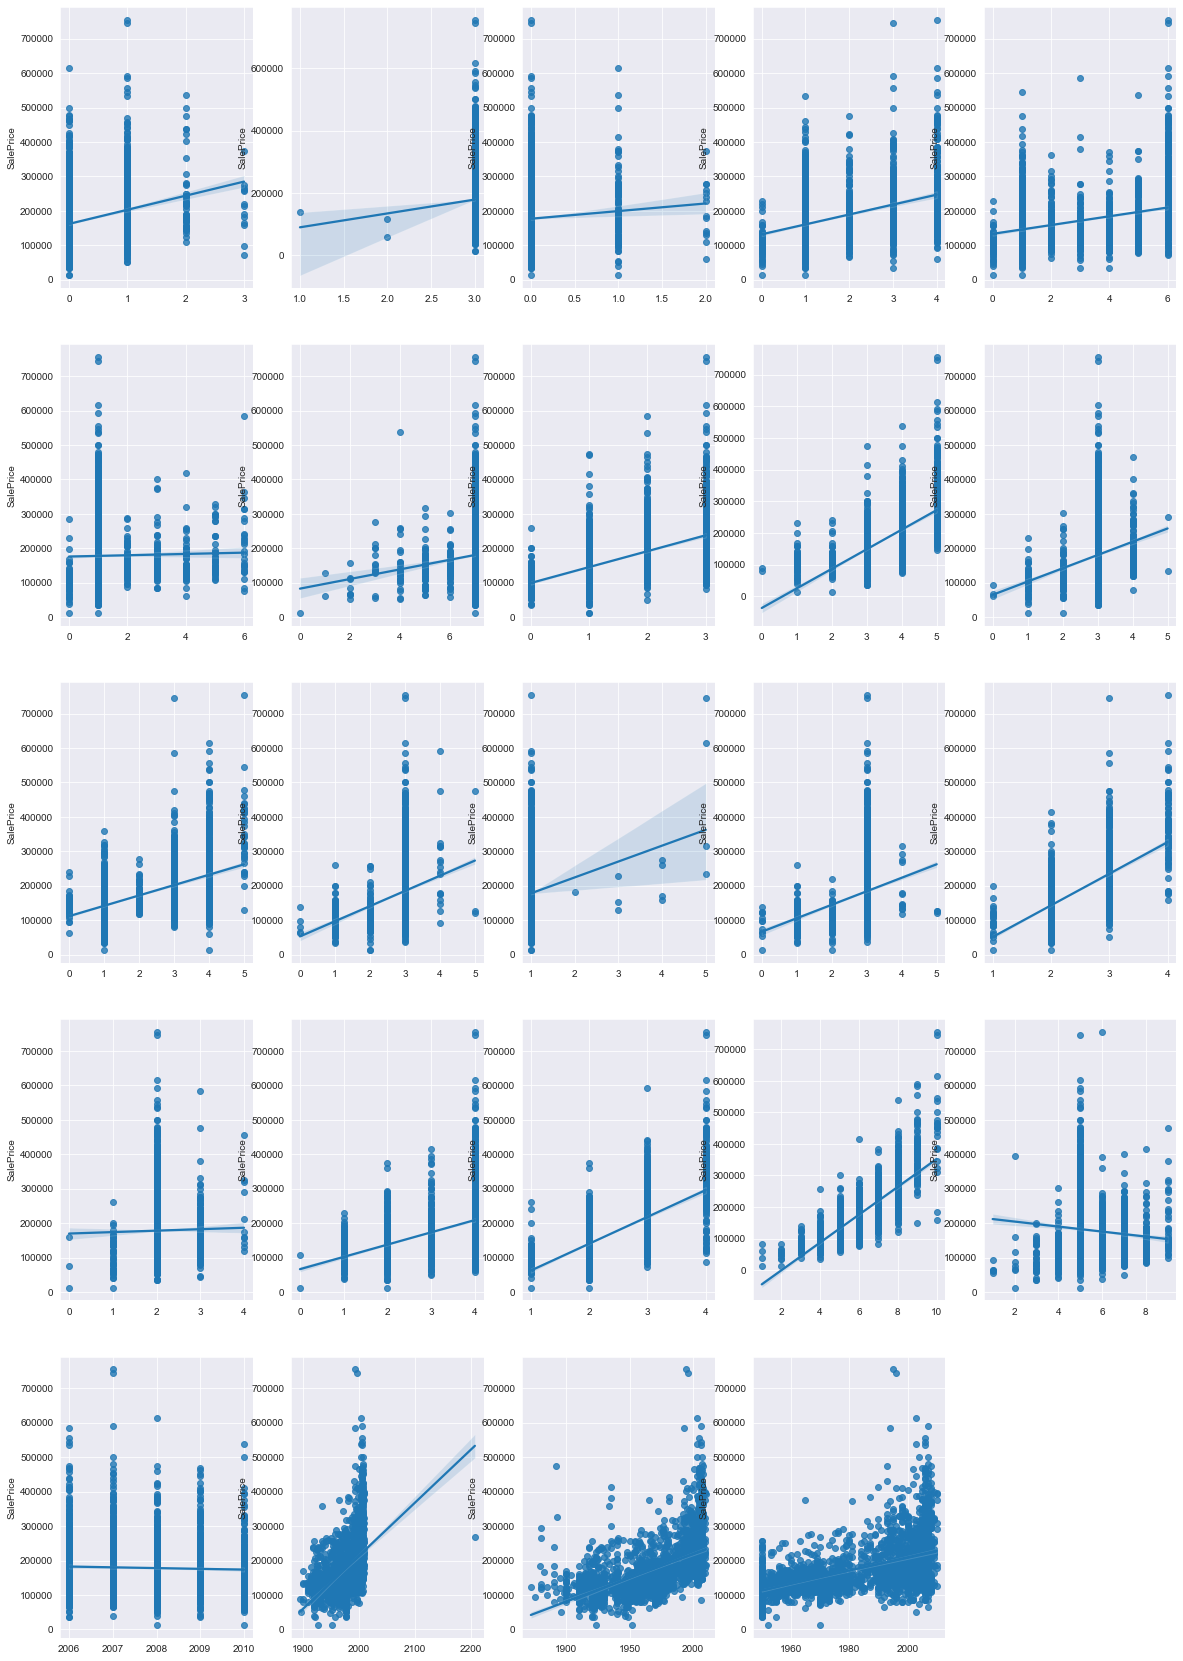

In [318]:
plt.figure(figsize=(20,30))
for i in range(test_data.shape[1]):
    ax = plt.subplot(math.ceil(test_data.shape[1] / 5), 5, i+1)
    fig = sns.regplot(x=test_data[:, i], y=y_train)

Overall Cond should be removed or modified, same for Utilities and another (not found).
There also is some outliers (eg. the 2200 in Garage Yr Blt)

### Understanding and cleaning the data

In [319]:
categorical_features = ['MS SubClass', 'MS Zoning',
        'Street', 'Lot Shape', 'Land Contour', 'Utilities',
        'Lot Config', 'Land Slope', 'Neighborhood', 'Condition 1',
        'Condition 2', 'Bldg Type', 'House Style', 'Overall Qual',
        'Overall Cond', 'Roof Style',
        'Roof Matl', 'Exterior 1st', 'Exterior 2nd', 
        'Mas Vnr Type', 'Exter Qual',
        'Exter Cond', 'Foundation', 'Bsmt Qual', 'Bsmt Cond', 'Bsmt Exposure',
        'BsmtFin Type 1',  'BsmtFin Type 2', 
        'Heating', 'Heating QC', 'Central Air',
        'Electrical',  'Bsmt Full Bath', 'Bsmt Half Bath', 'Full Bath',
        'Half Bath', 'Bedroom AbvGr', 'Kitchen AbvGr', 'Kitchen Qual',
        'TotRms AbvGrd', 'Functional', 'Fireplaces' , 'Garage Type',
        'Garage Finish', 'Garage Cars', 
        'Garage Qual', 'Paved Drive', 'Mo Sold', 'Sale Type',
        'Sale Condition', 'Fireplace Qu', 'Pool QC', 'Garage Cond', 'Yr Sold'
        ] # 'Alley', 'Fence', 'Misc Feature'

numerical_features = ['Lot Frontage', 'Lot Area', 'Mas Vnr Area','BsmtFin SF 1','BsmtFin SF 2','Bsmt Unf SF',
        'Total Bsmt SF','1st Flr SF', '2nd Flr SF', 'Low Qual Fin SF',
        'Gr Liv Area', 'Garage Area','Wood Deck SF',
        'Open Porch SF', 'Enclosed Porch', '3Ssn Porch', 'Screen Porch',
        'Pool Area', 'Misc Val', 'Garage Yr Blt', 'Year Built', 'Year Remod/Add']

ordinal_features = ['Lot Shape', 'Utilities', 'Land Slope',  'Overall Qual', 'Overall Cond',
                'Exter Qual', 'Exter Cond', 'Bsmt Qual', 'Bsmt Cond', 'Bsmt Exposure', 'BsmtFin Type 1', 
                'BsmtFin Type 2', 'Heating QC', 'Kitchen Qual', 'Functional', 'Fireplace Qu', 'Garage Finish',
                'Garage Qual', 'Garage Cond', 'Pool QC', 'Yr Sold', 'Garage Yr Blt', 'Year Built', 'Year Remod/Add']

#### Data distribution

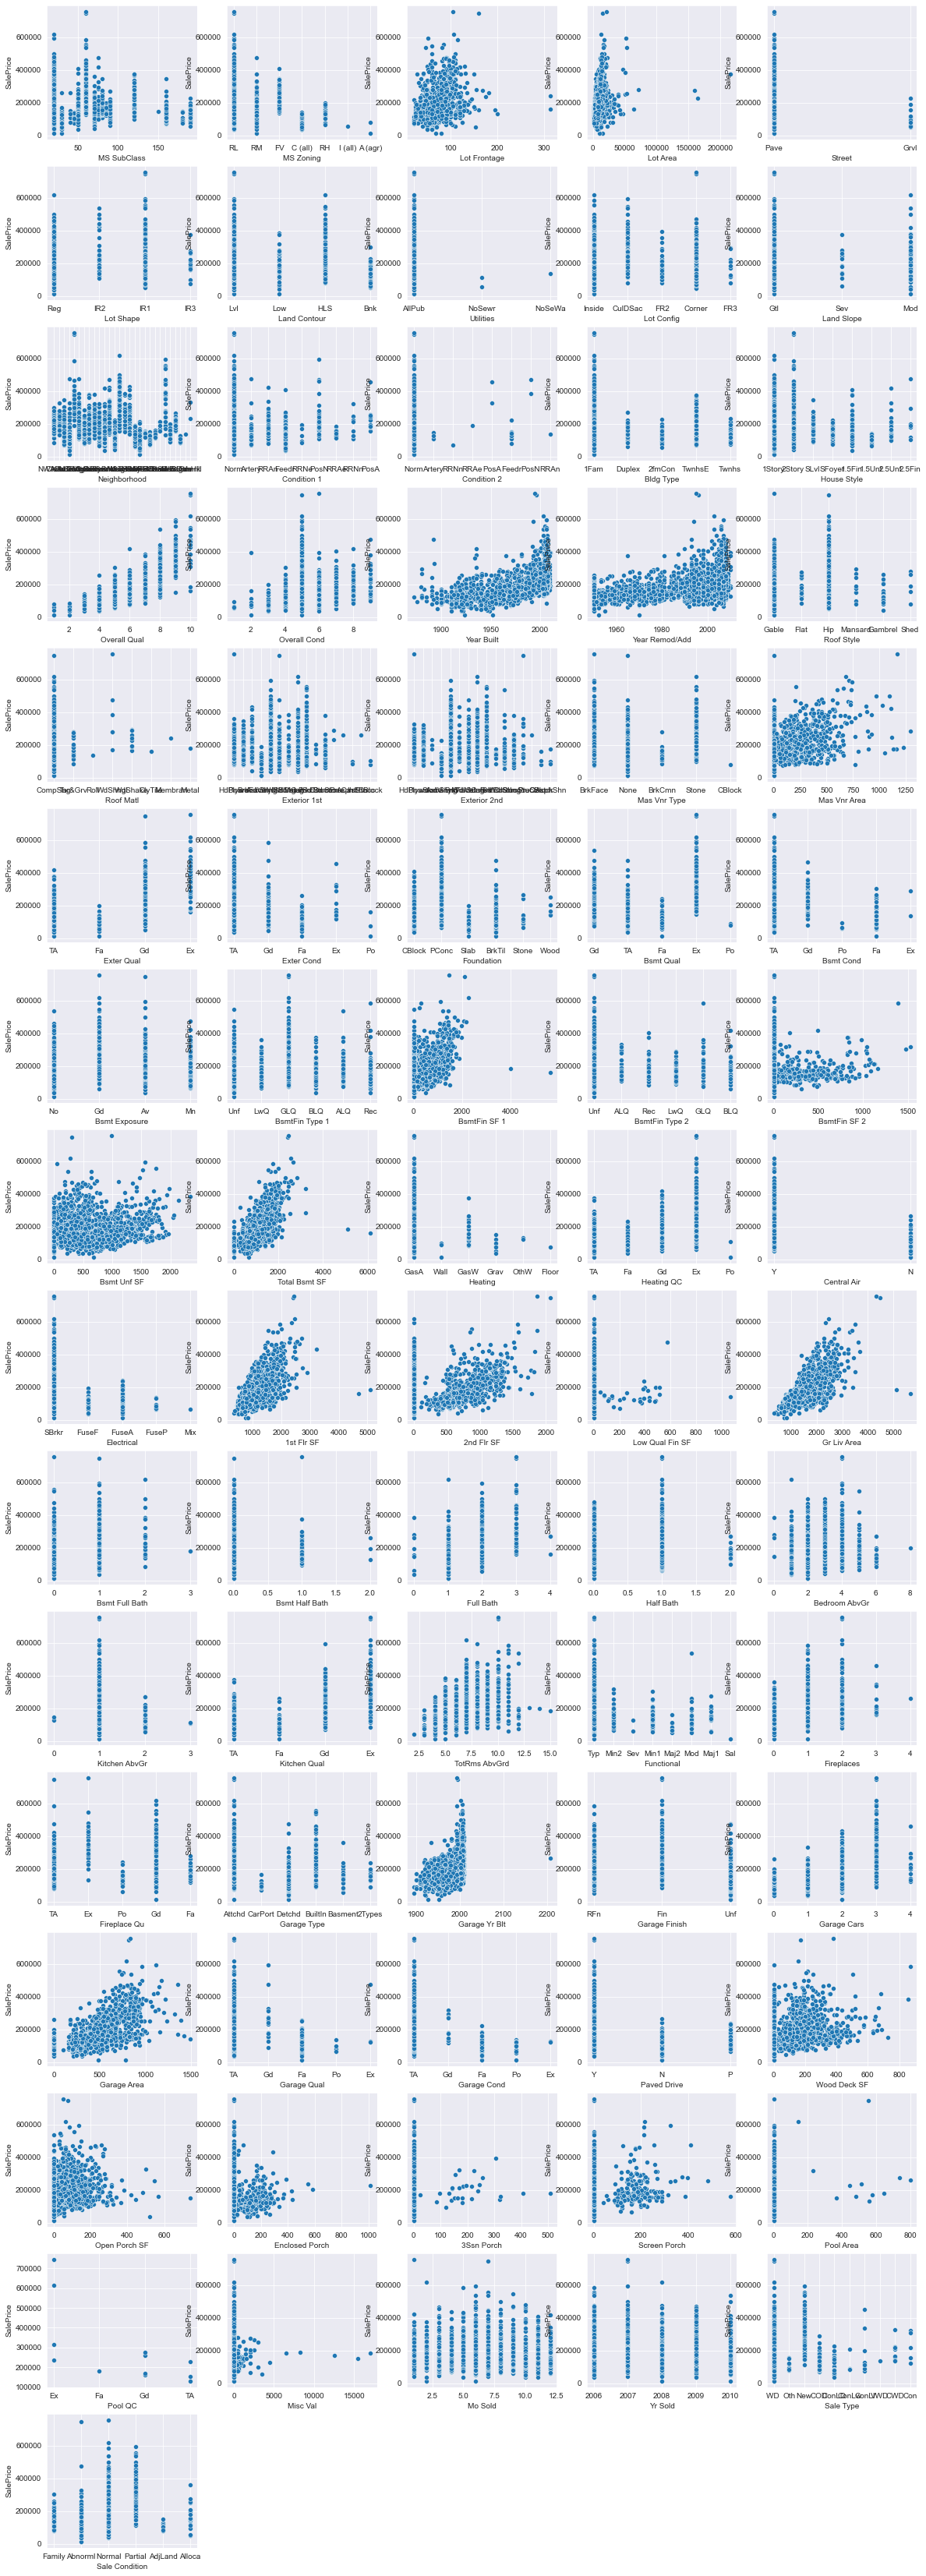

In [320]:
plt.figure(figsize=(20,60))
for i, col in enumerate(X_train.columns):
    ax = plt.subplot(math.ceil(len(df_train.columns) / 5), 5, i+1)
    sns.scatterplot(data=X_train, x=col, y=df_train["SalePrice"], ax=ax)

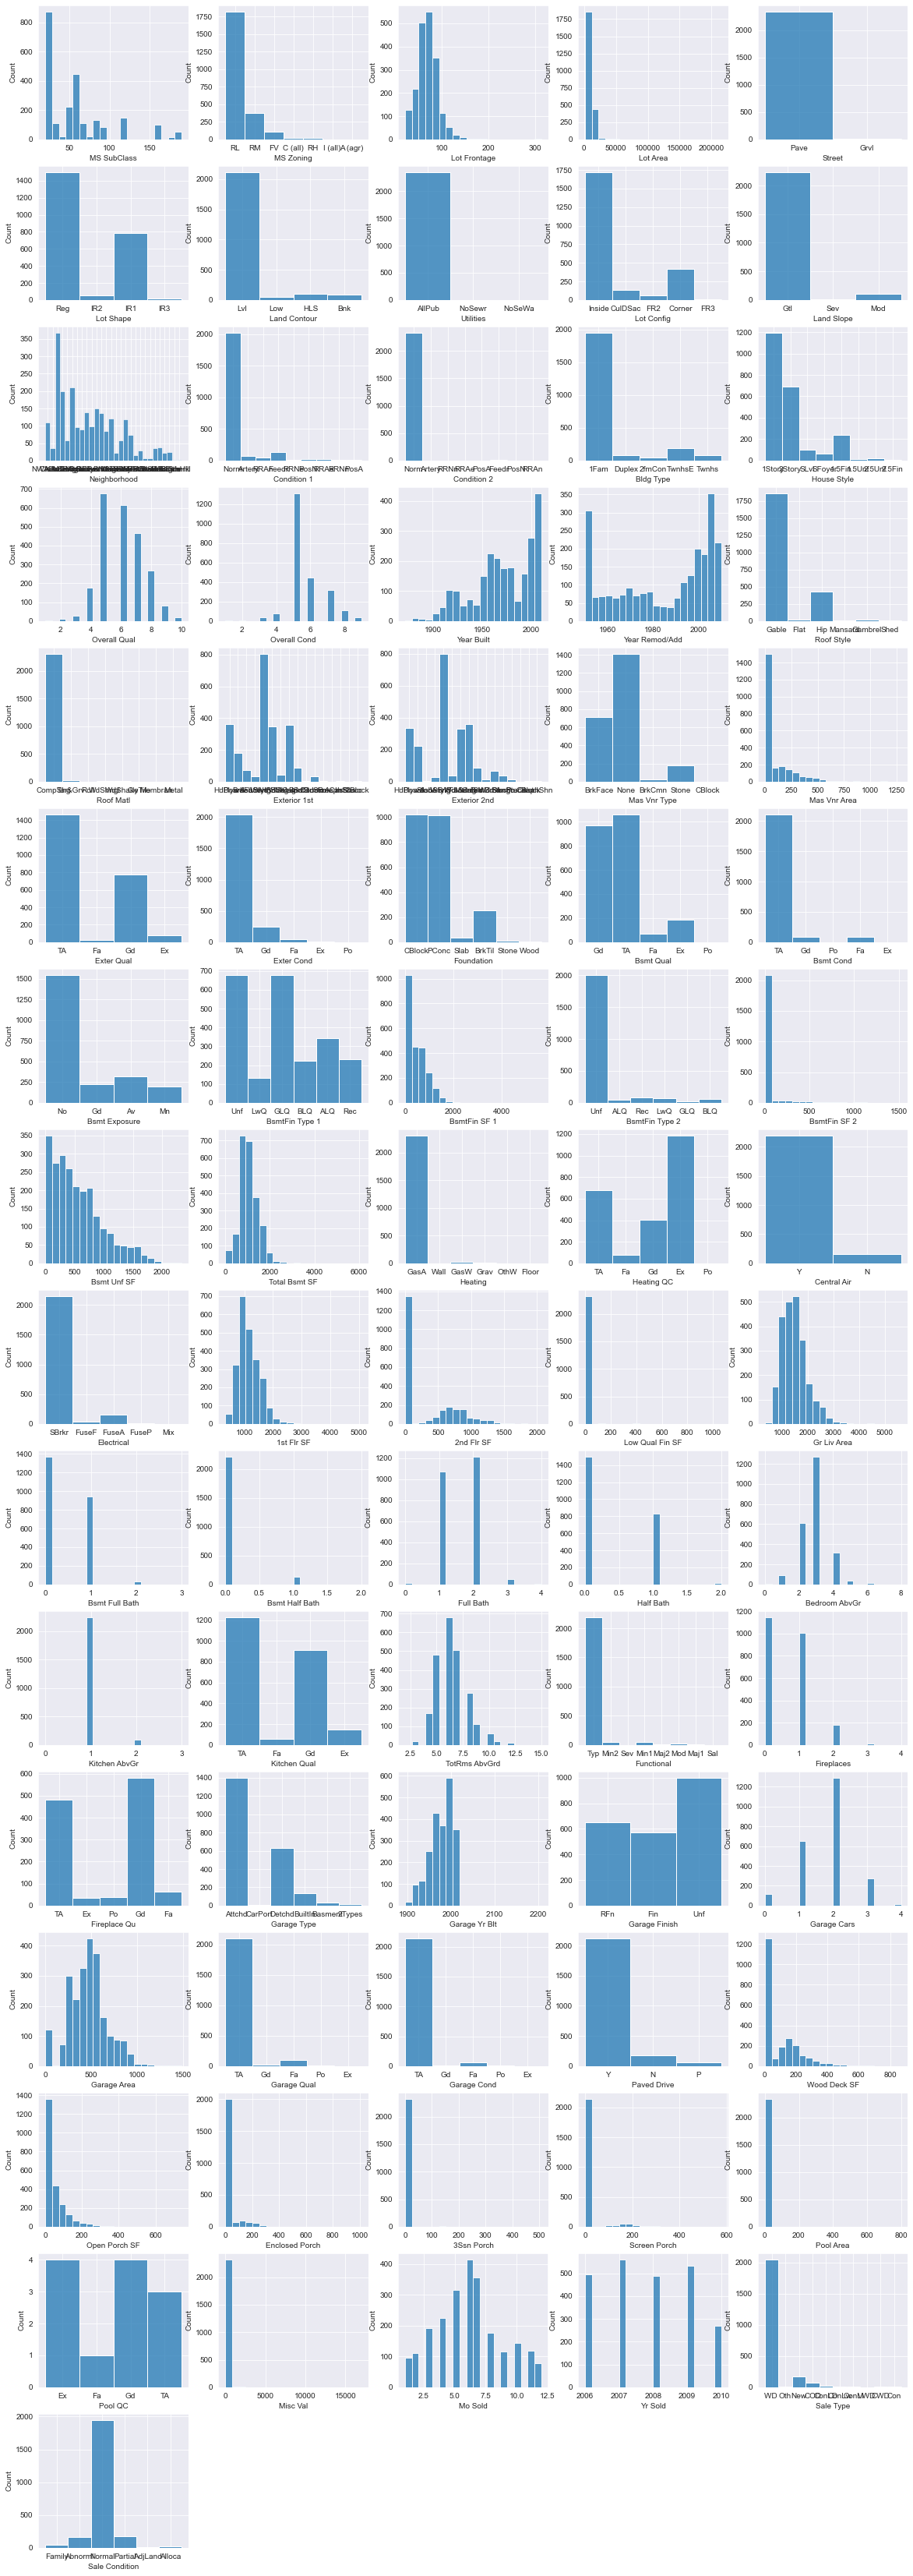

In [321]:
plt.figure(figsize=(20,60))
for i, col in enumerate(X_train.columns):
    ax = plt.subplot(math.ceil(len(df_train.columns) / 5), 5, i+1)
    sns.histplot(data=X_train, x=col, ax=ax, bins=20)

#### Missing values
Something to note is that some `None` in this dataset actually mean something (eg. None is the basement quality means that there is no basement).

<AxesSubplot:>

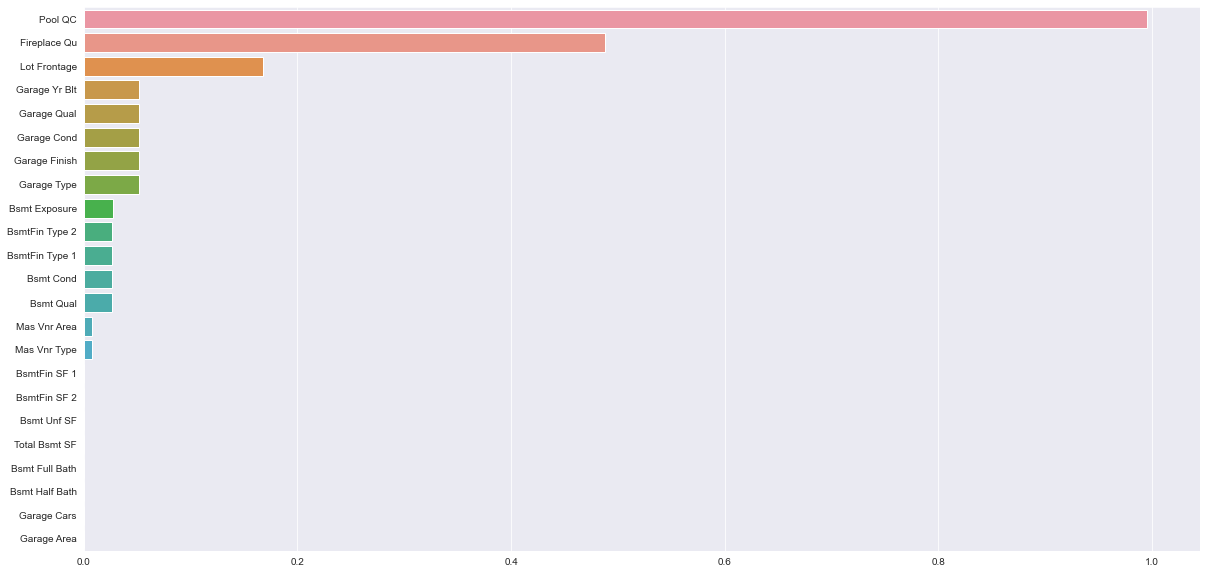

In [322]:
plt.figure(figsize=(20, 10))
missing_values_proportion = df_train.isnull().mean().sort_values(ascending=False)
missing_values_proportion = missing_values_proportion[missing_values_proportion > 0]
sns.barplot(x=missing_values_proportion, y=missing_values_proportion.index)

#### Quantify the unique values

<AxesSubplot:>

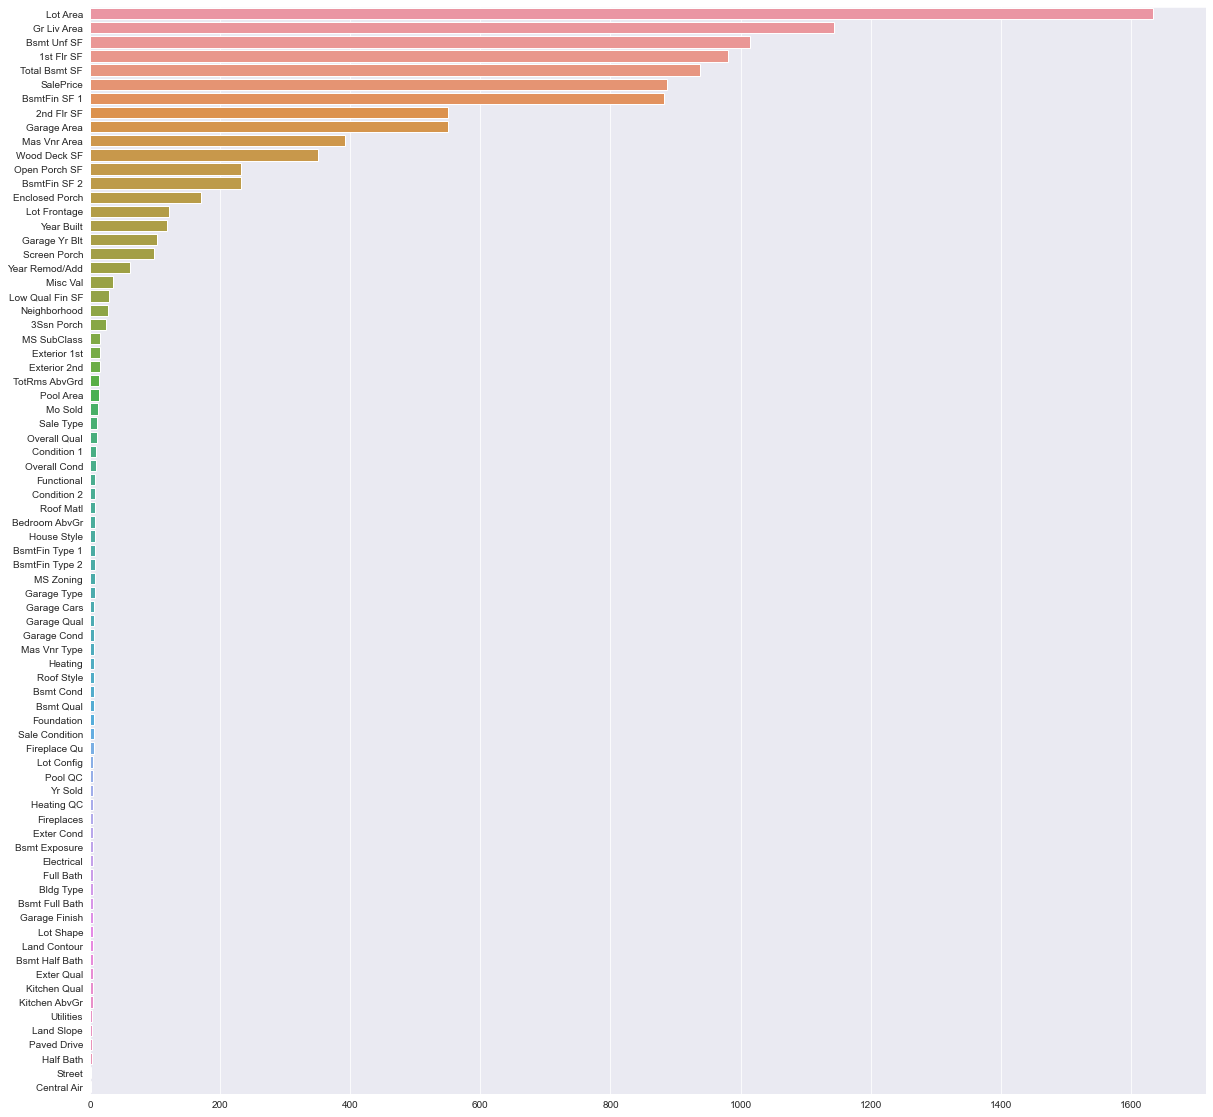

In [323]:
plt.figure(figsize=(20, 20))
unique_values_proportion = df_train.nunique(dropna=False).sort_values(ascending=False)
sns.barplot(x=unique_values_proportion, y=unique_values_proportion.index)

#### Identify the rare categories
The red line on the graphs represents 5% of the data. We can say that values under that are rare.

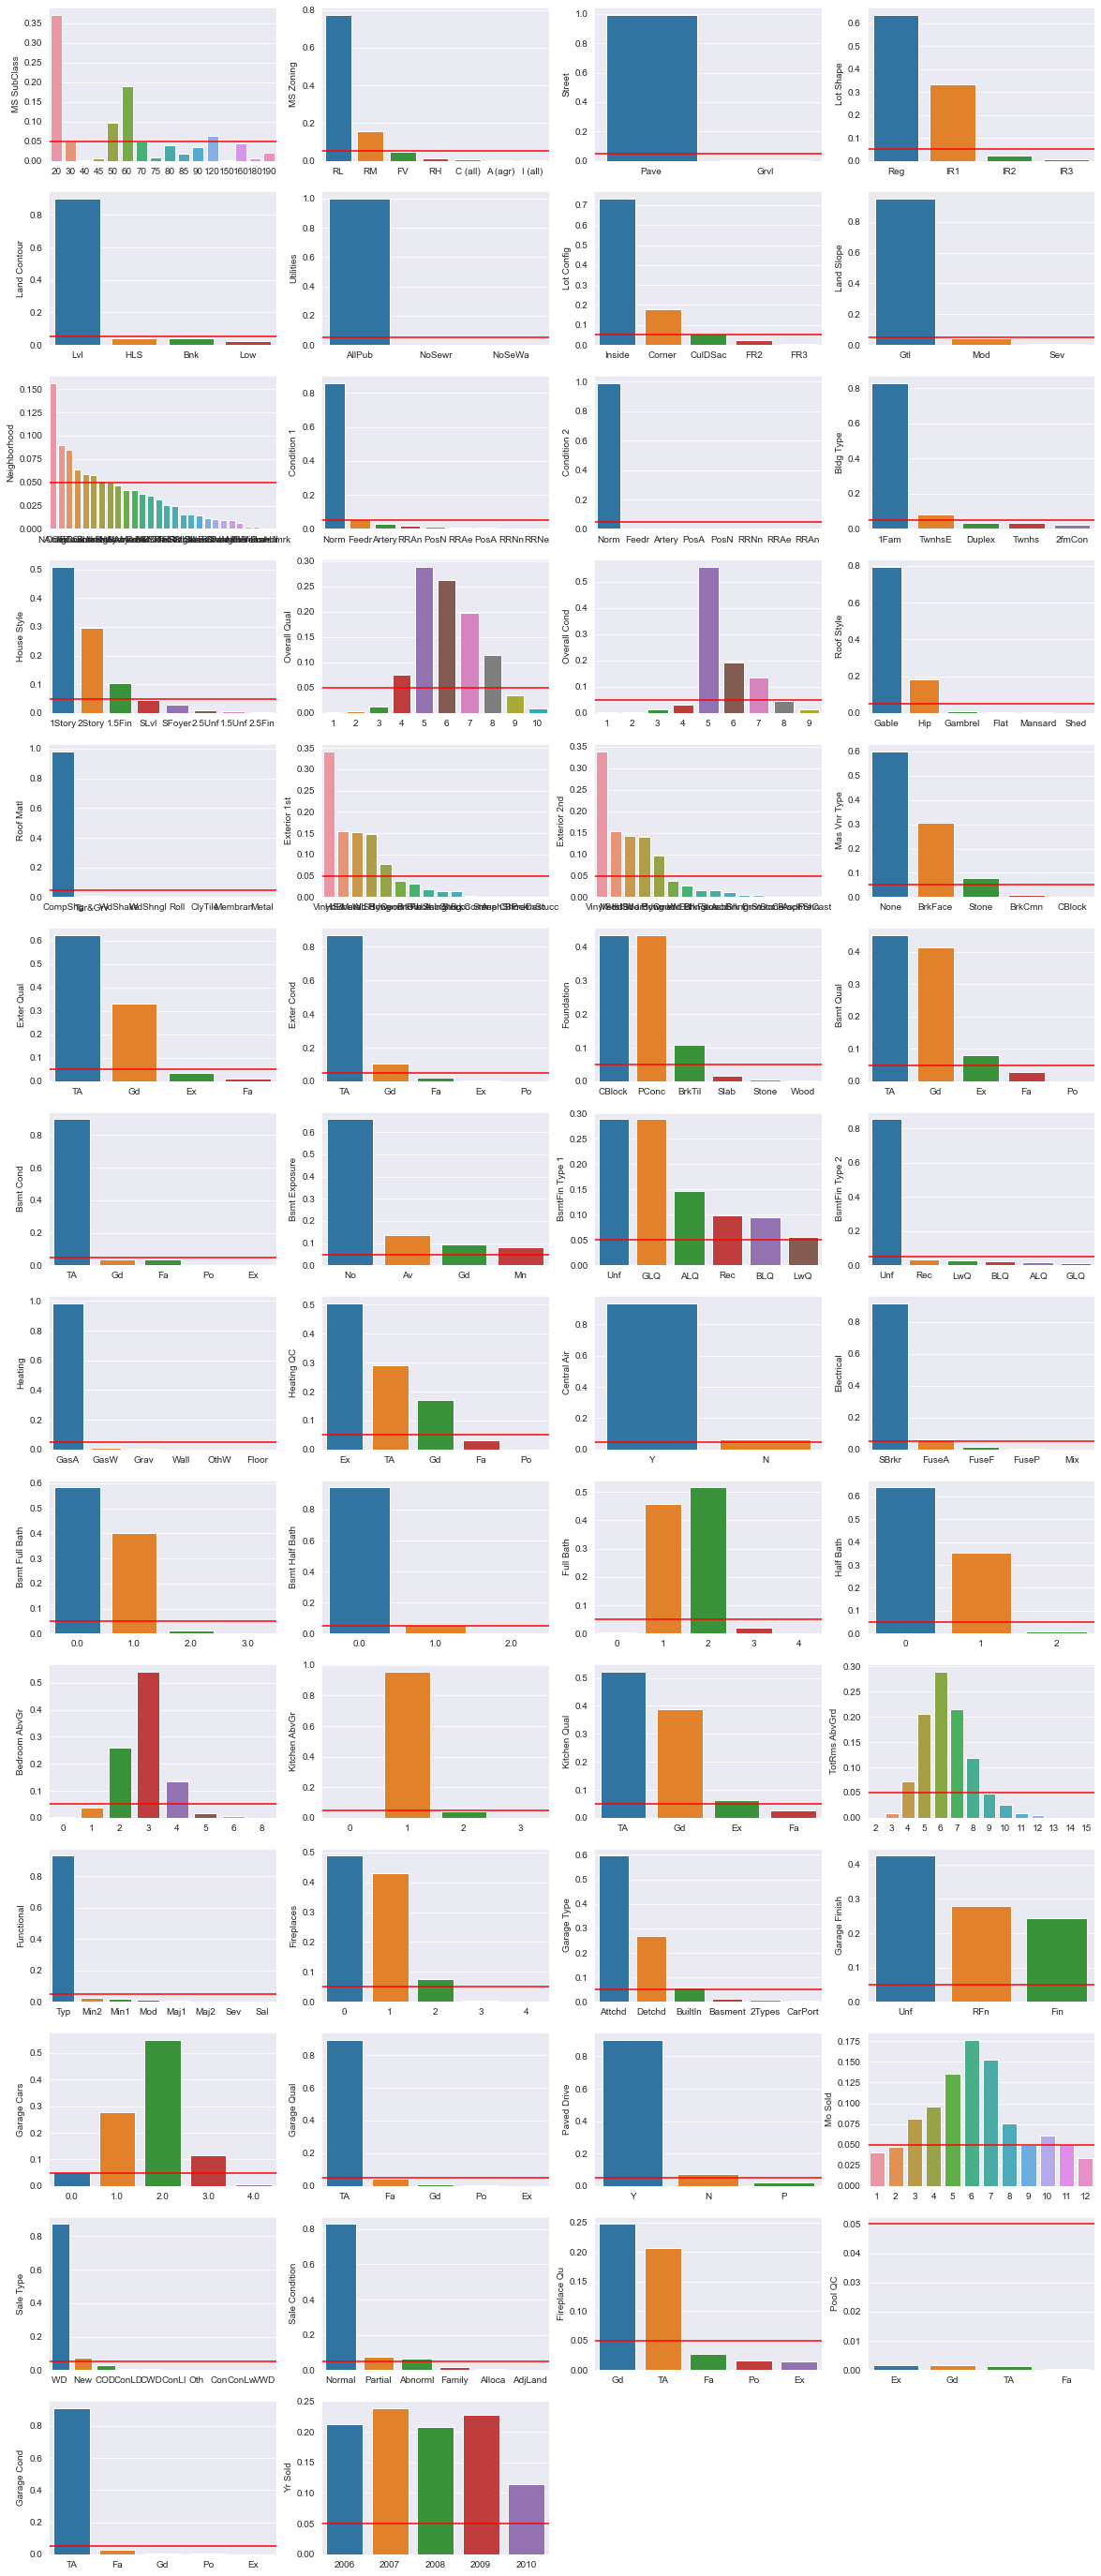

In [324]:
plt.figure(figsize=(20,50))
for i, cat in enumerate(categorical_features):
    ax = plt.subplot(math.ceil(len(categorical_features) / 4), 4, i+1)
    value_count = df_train[cat].value_counts() / len(df_train[cat])
    fig = sns.barplot(x=value_count.index, y=value_count)
    fig.axhline(y=0.05, color="red")

#### Evaluate linear relationships

In [325]:
plt.rcParams.update({"figure.max_open_warning": 0})

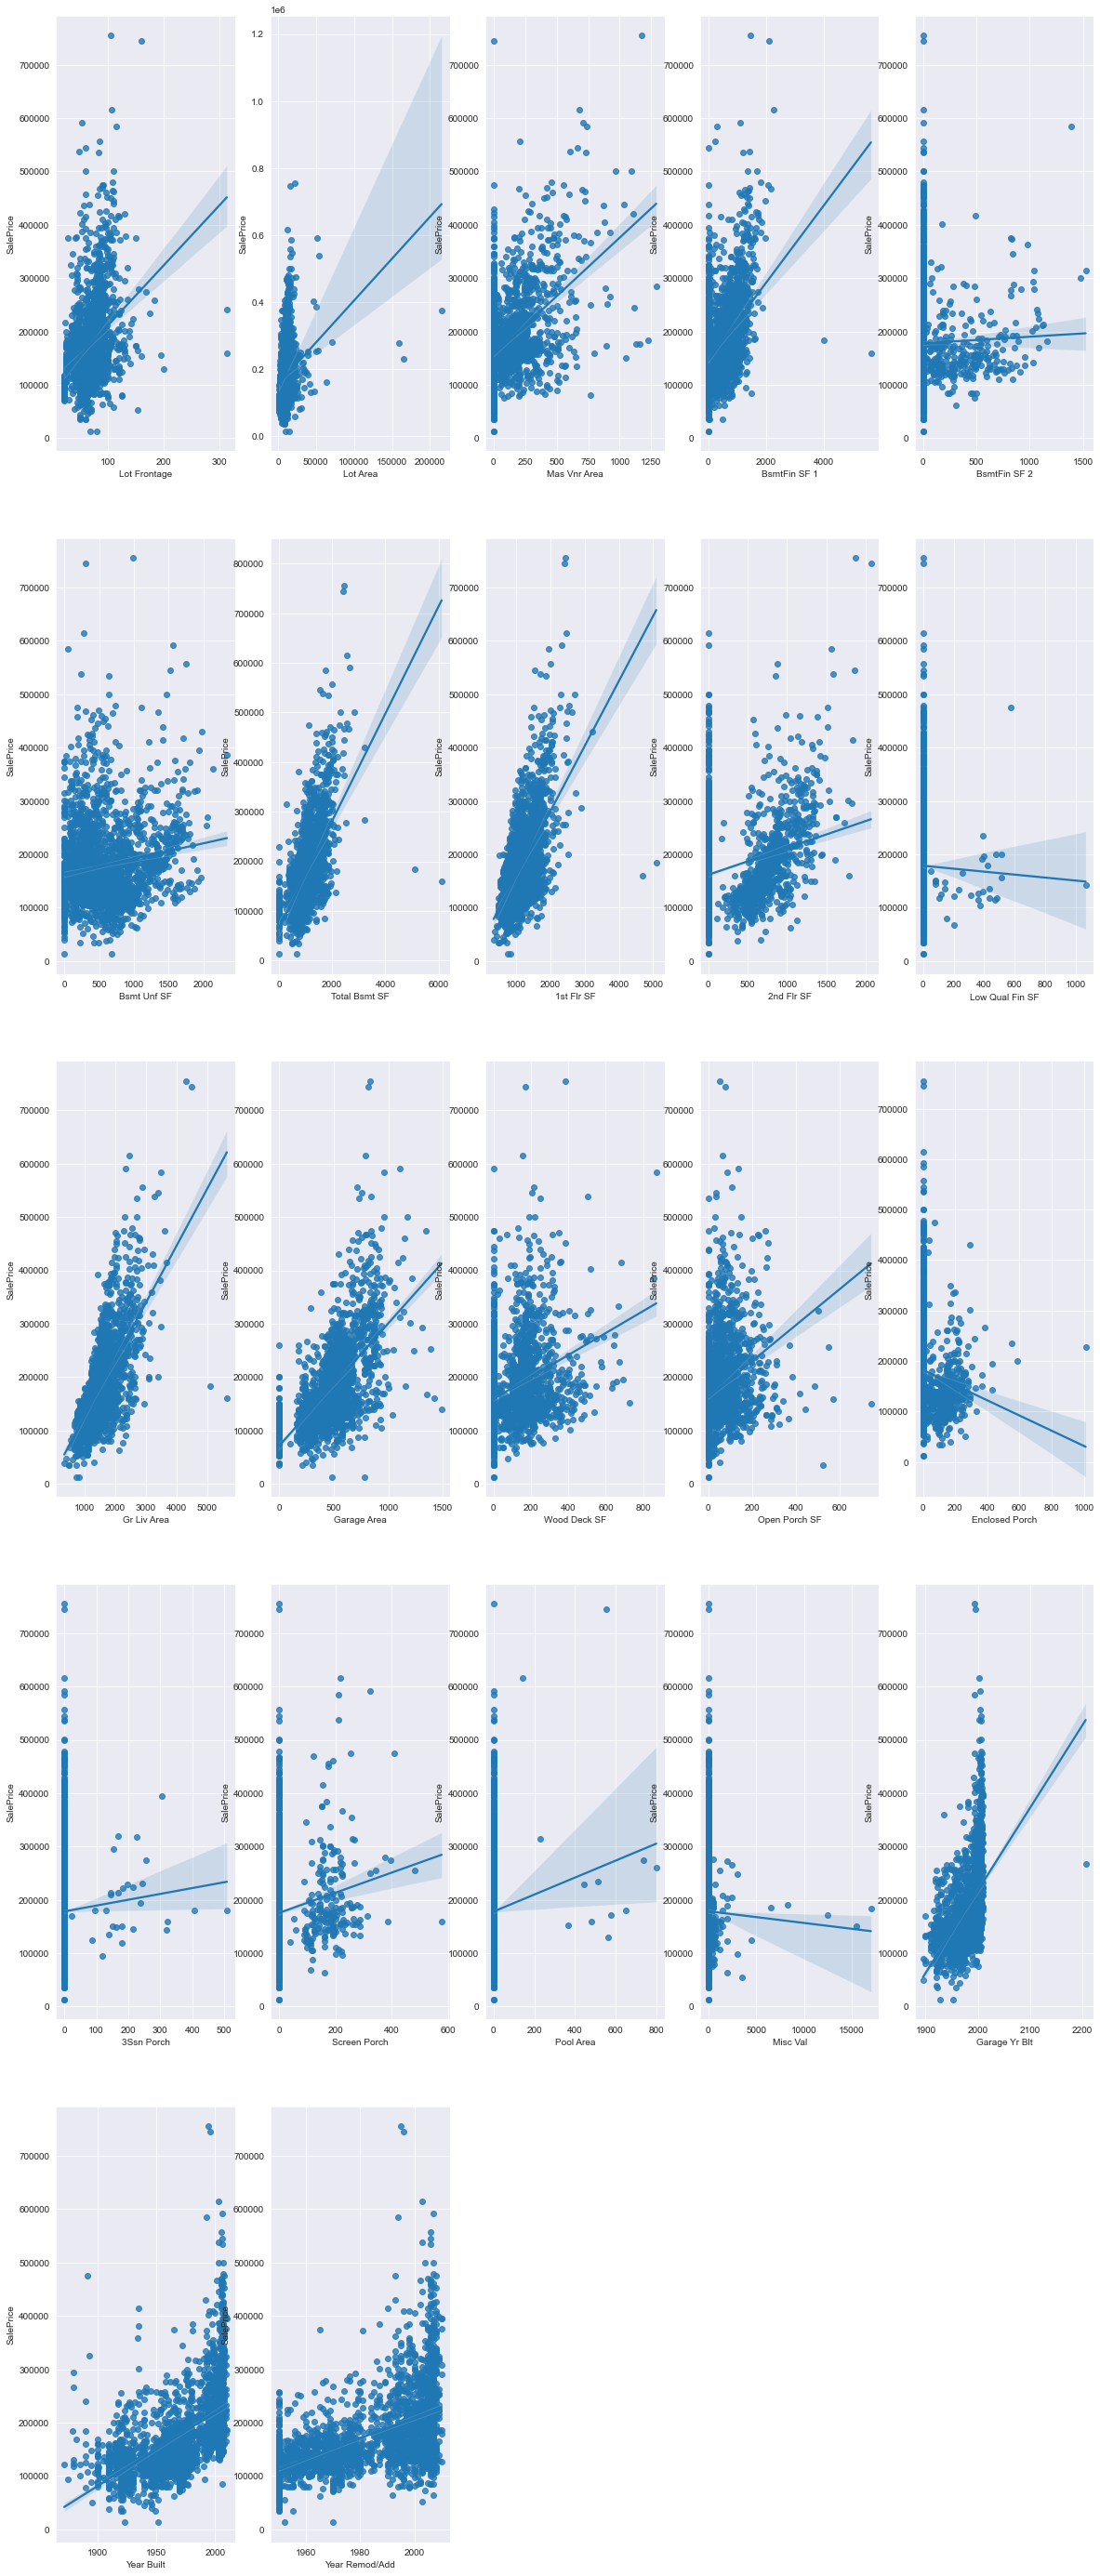

In [326]:
plt.figure(figsize=(20,50))
for i, col in enumerate(numerical_features):
    ax = plt.subplot(math.ceil(len(numerical_features) / 5), 5, i+1)
    fig = sns.regplot(data=df_train, x=col, y="SalePrice")

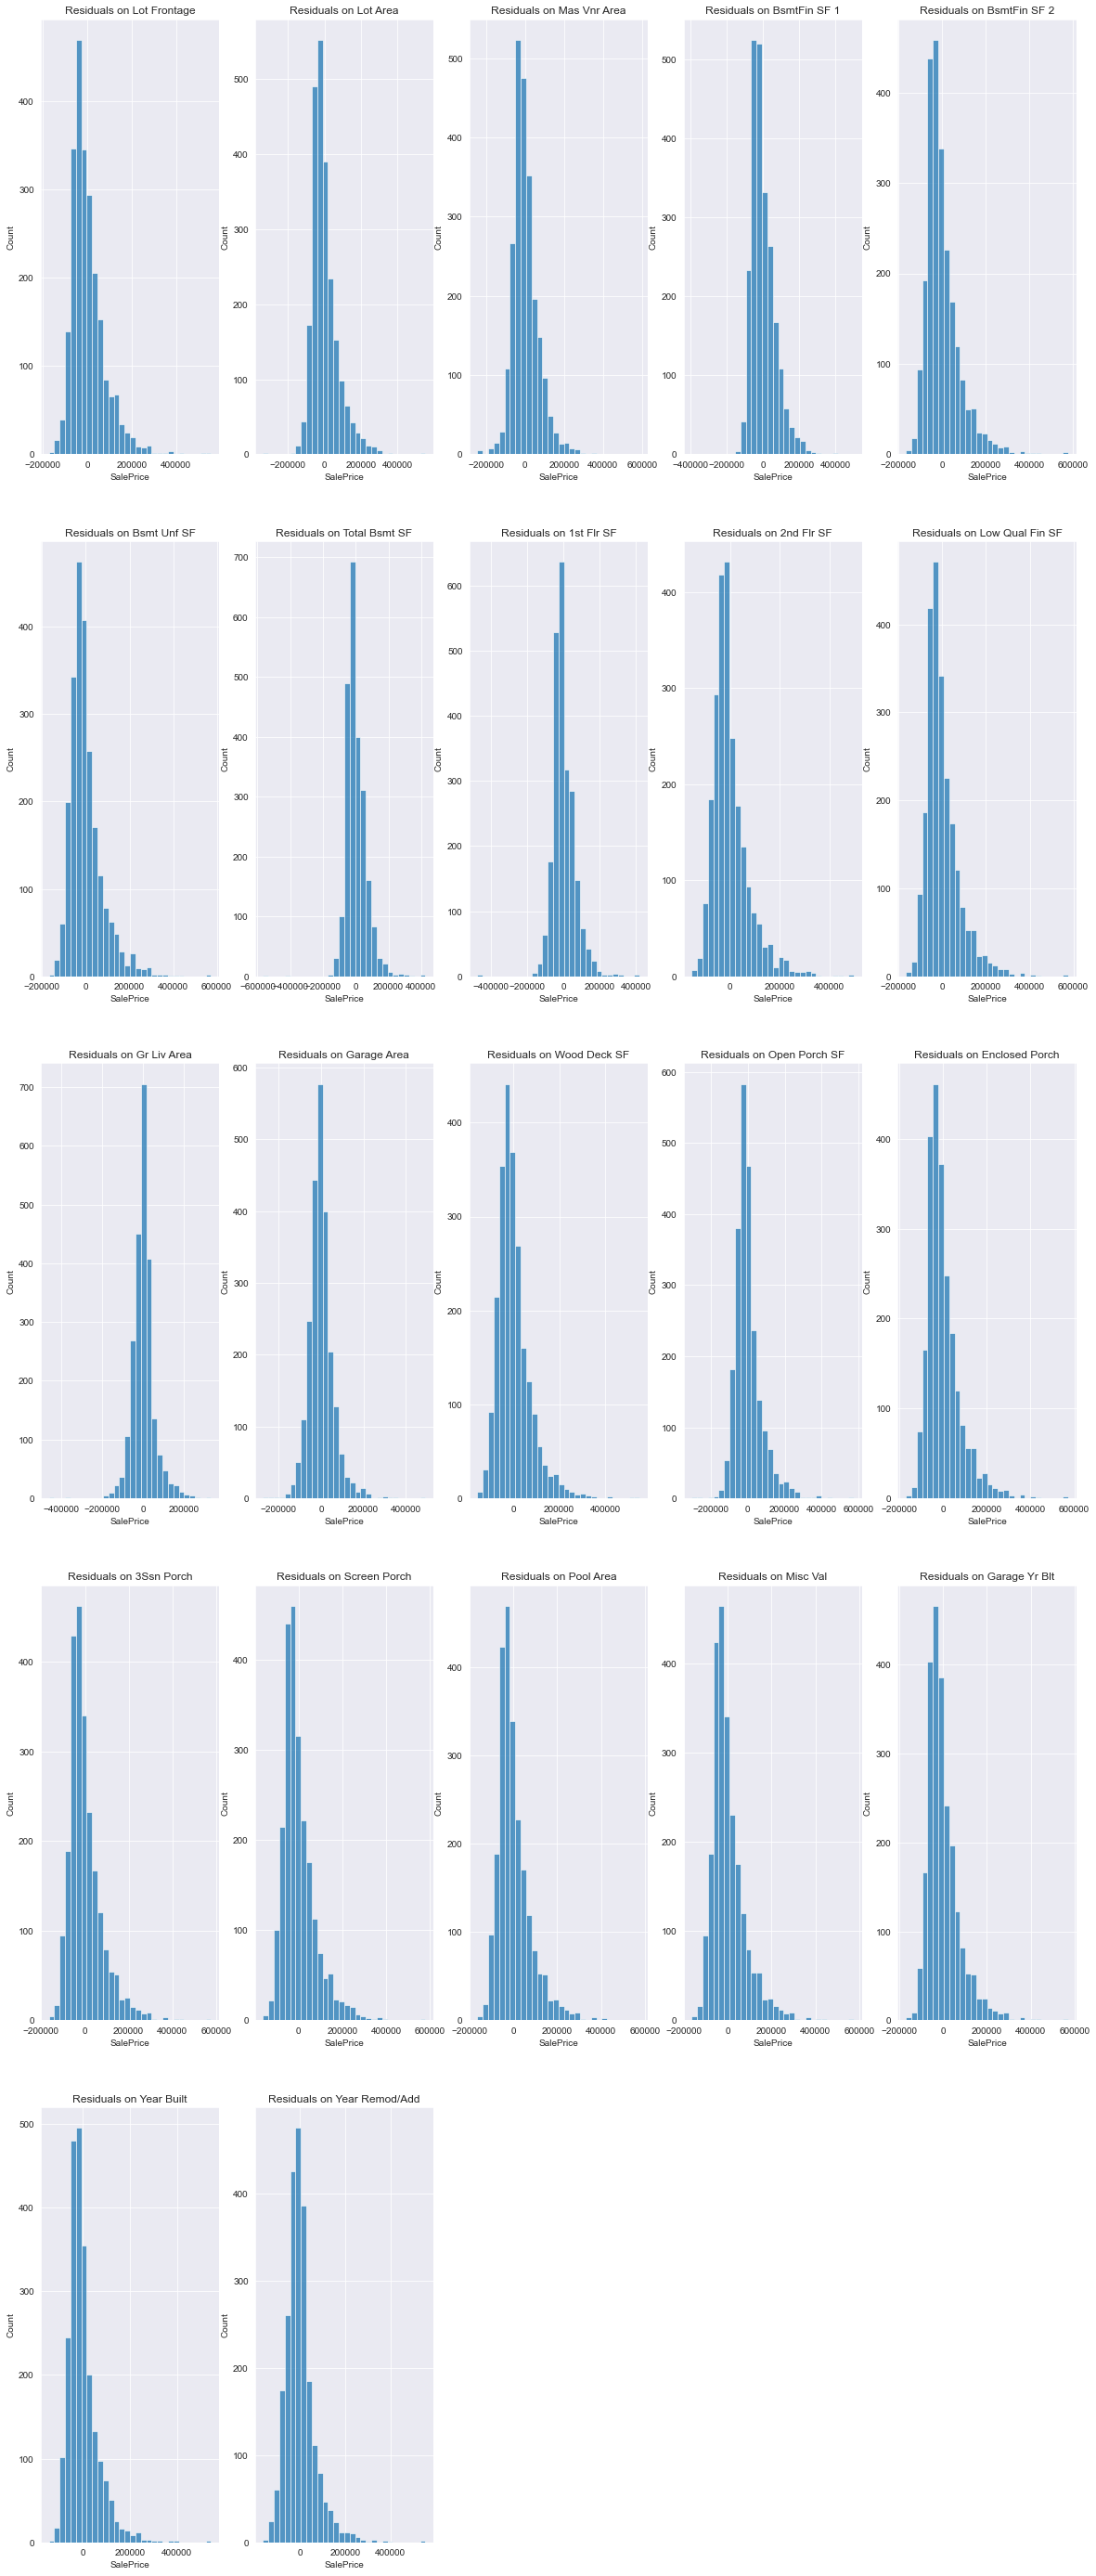

In [327]:
plt.figure(figsize=(20,50))
for i, col in enumerate(numerical_features):
    ax = plt.subplot(math.ceil(len(numerical_features) / 5), 5, i+1)

    model = LinearRegression()
    model.fit(df_train[[col]].fillna(0), df_train["SalePrice"])
    pred = model.predict(df_train[[col]].fillna(0))
    residuals = df_train["SalePrice"] - pred

    fig = sns.histplot(residuals, bins=30, ax=ax)
    plt.title(f"Residuals on {col}")

#### QQ Plots and variable distribution
We want our data to follow **normal distribution**. On this plot, a normal distribution would be the blue point ascending at a 45deg angle ("1st Flr SF" is the closest to that).

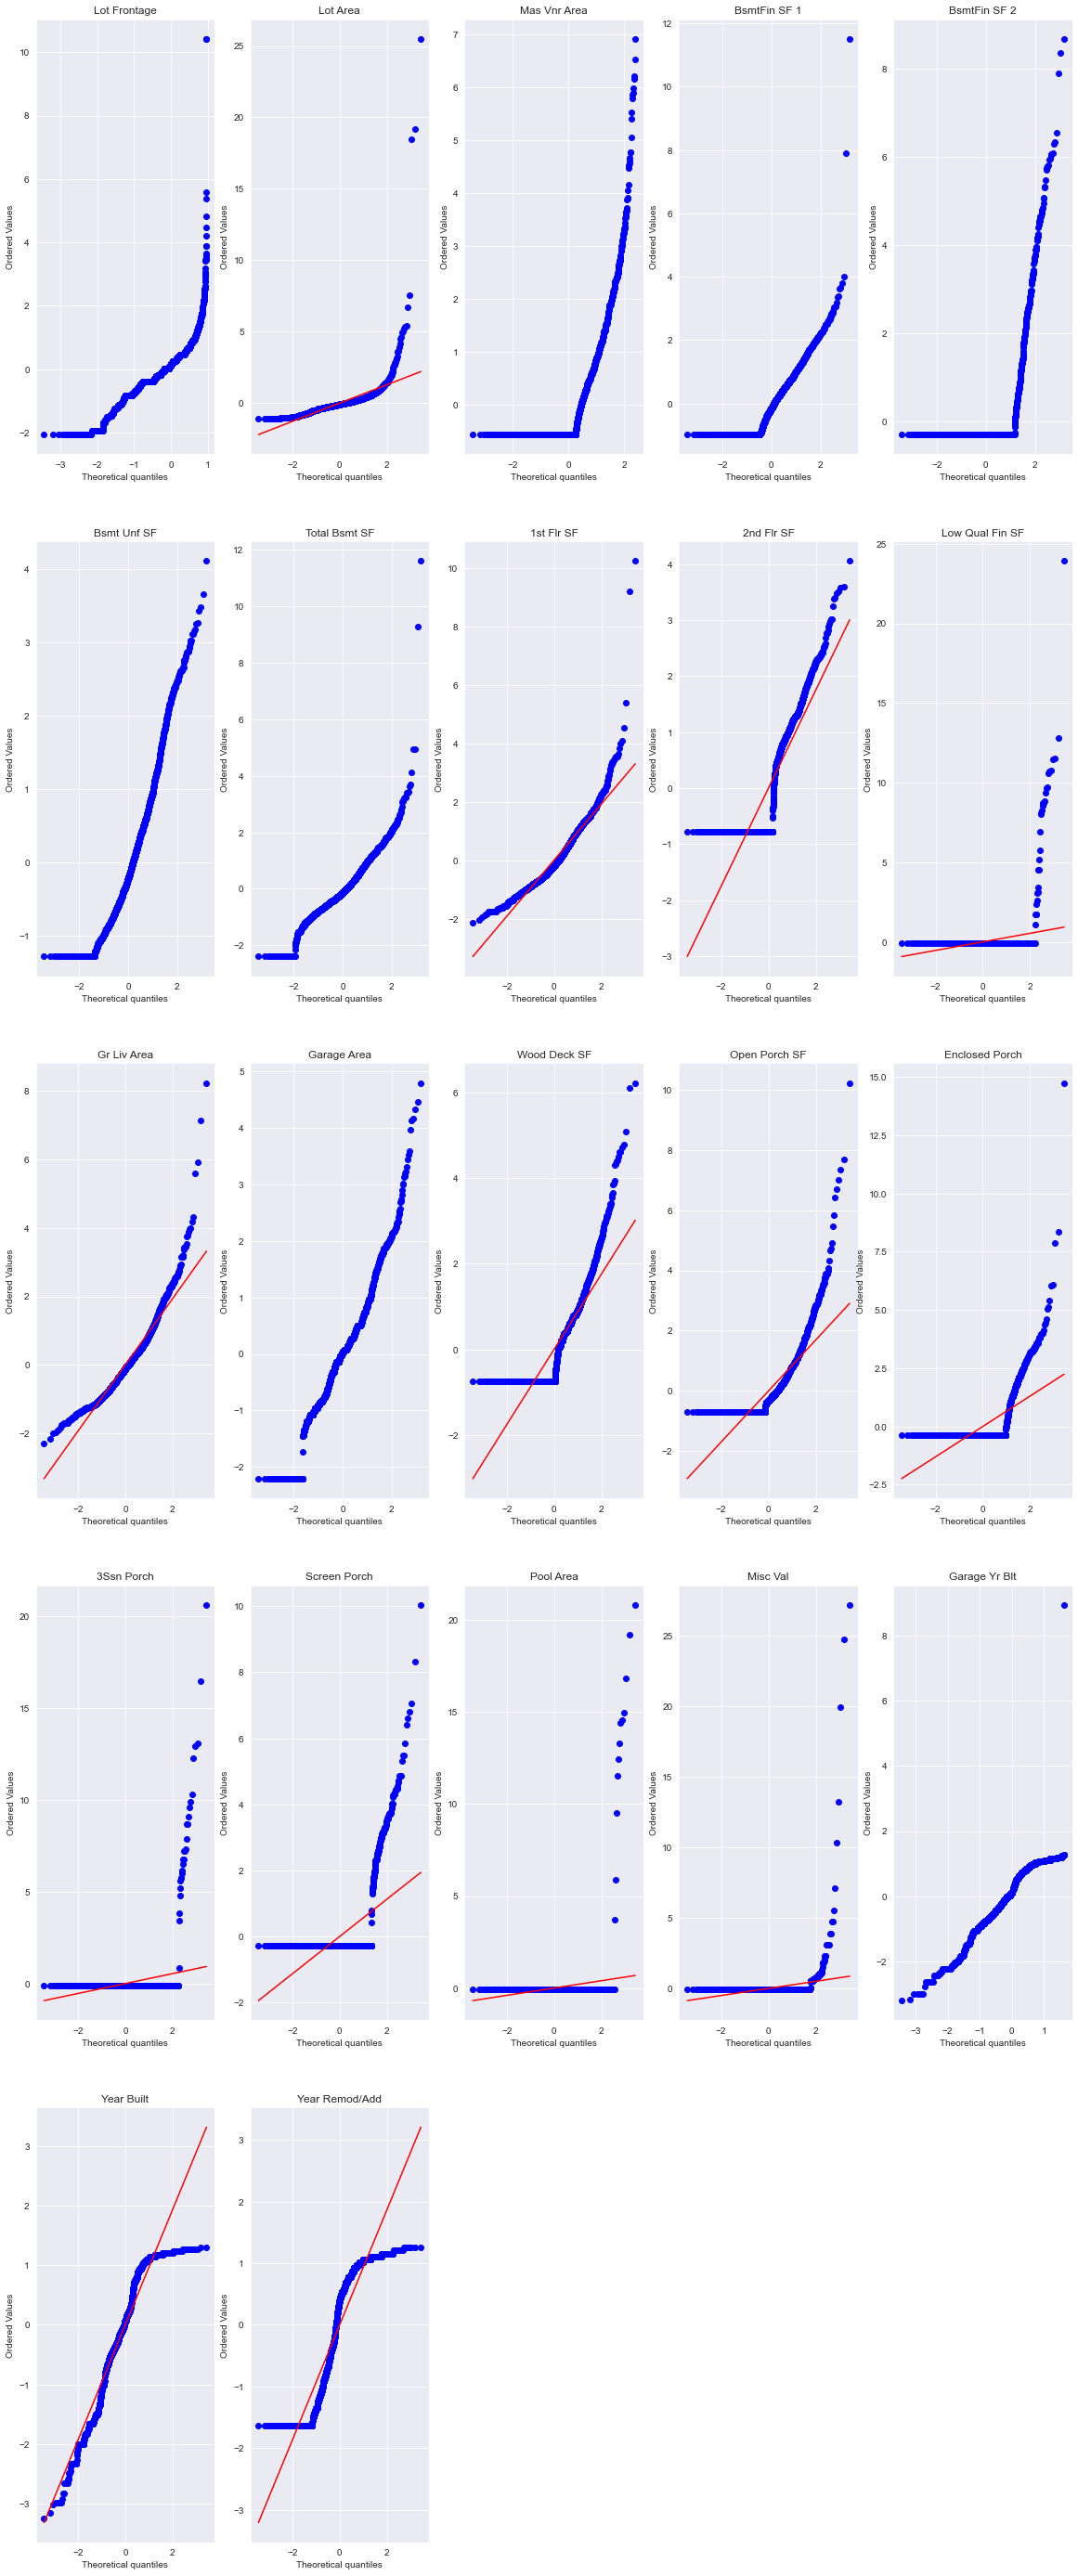

In [328]:
import scipy.stats as stats

plt.figure(figsize=(20,50))
for i, col in enumerate(numerical_features):
    ax = plt.subplot(math.ceil(len(numerical_features) / 5), 5, i+1)
    # fig = sns.regplot(data=df_train, x=col, y="SalePrice")
    normalized_col = StandardScaler().fit_transform(df_train[[col]]).reshape(-1)
    stats.probplot(normalized_col, dist="norm", plot=plt)
    plt.title(col)

#### Identify possible outliers

In [329]:
def find_boundaries(df, variable, distance):
    IQR = df[variable].quantile(0.75) - df[variable].quantile(0.25)
    lower_boundary = df[variable].quantile(0.25) - (IQR * distance)
    upper_boundary = df[variable].quantile(0.75) + (IQR * distance)
    return upper_boundary, lower_boundary

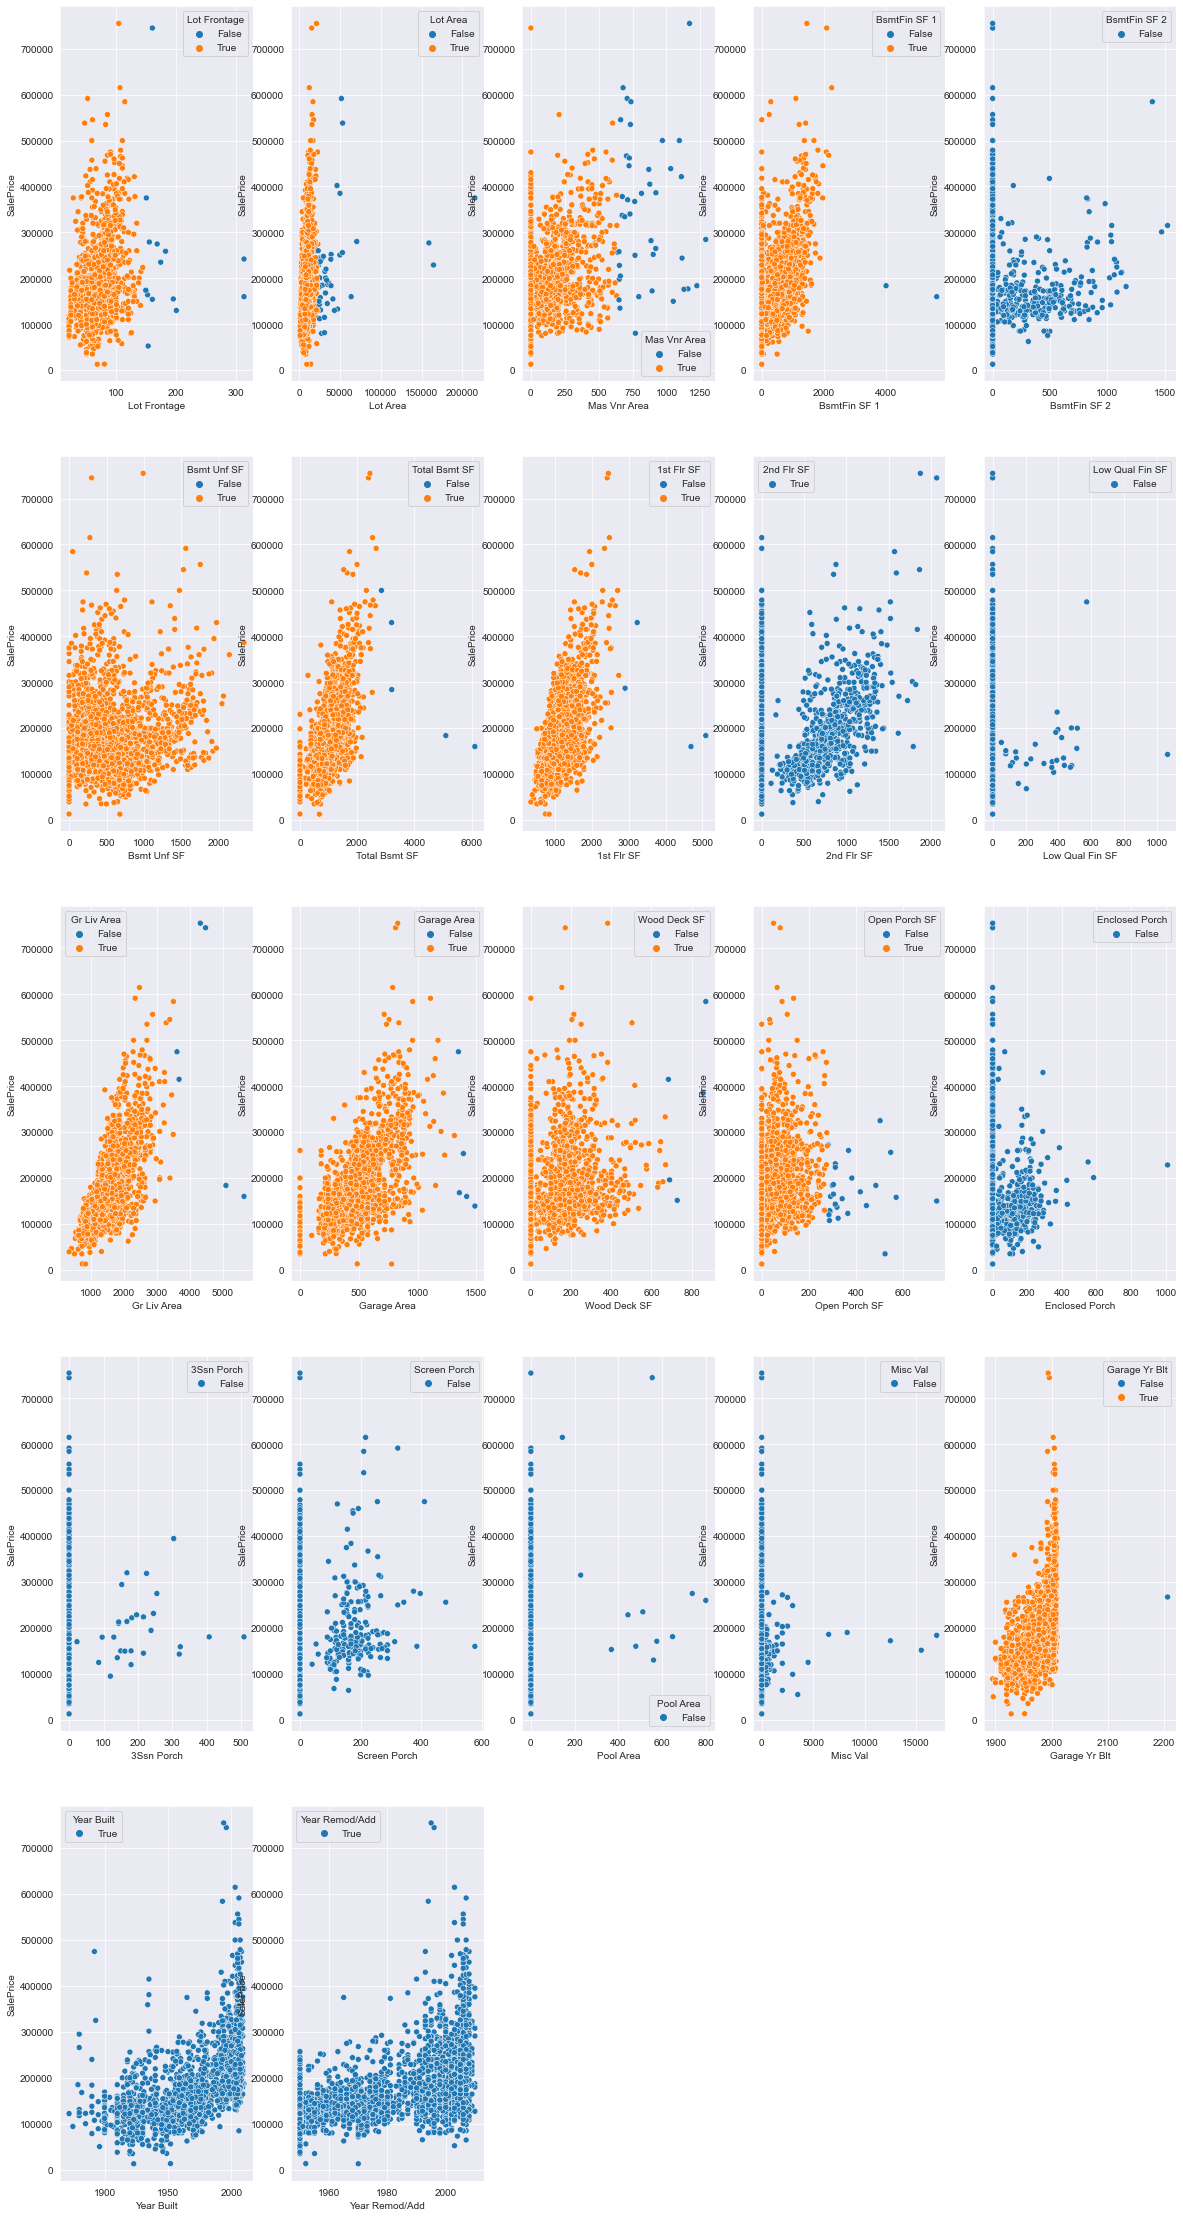

In [330]:
plt.figure(figsize=(20,40))
for i, col in enumerate(numerical_features):
    ax = plt.subplot(math.ceil(len(numerical_features) / 5), 5, i+1)

    upper, lower = find_boundaries(X_train, col, 3)
    mask = (X_train[col] < upper) & (X_train[col] > lower)

    sns.scatterplot(data=X_train, x=col, y=df_train["SalePrice"], hue=mask, ax=ax)


Most of the outliers shown here really are rare values rather than outliers. This is because the dataset can be very imbalanced. However, some values, such as in "Garage Yr Blt", "BsmtFin SF 1" or "Open porch SF" can really be outliers.

#### Cleaning the data and train a basic model

We will remove some problematic columns such as Enclosed Porch and remove outliers.

In [331]:
df_train_clean = df_train.drop(["Enclosed Porch"], axis=1).copy()
total_mask = []

for col, dist in zip(["Garage Yr Blt", "BsmtFin SF 1", "Open Porch SF", "Total Bsmt SF", "1st Flr SF"], [3, 3, 6, 4, 4]):
    upper, lower = find_boundaries(df_train, col, 4)
    mask = (df_train[col] < upper) & (df_train[col] > lower)
    total_mask.append(mask)

mask = reduce(np.logical_and, total_mask)
df_train_clean = df_train_clean[mask]

In [332]:
categorical_features = ['MS SubClass', 'MS Zoning',
        'Street', 'Lot Shape', 'Land Contour', 'Utilities',
        'Lot Config', 'Land Slope', 'Neighborhood', 'Condition 1',
        'Condition 2', 'Bldg Type', 'House Style', 'Overall Qual',
        'Overall Cond', 'Roof Style',
        'Roof Matl', 'Exterior 1st', 'Exterior 2nd', 
        'Mas Vnr Type', 'Exter Qual',
        'Exter Cond', 'Foundation', 'Bsmt Qual', 'Bsmt Cond', 'Bsmt Exposure',
        'BsmtFin Type 1',  'BsmtFin Type 2', 
        'Heating', 'Heating QC', 'Central Air',
        'Electrical',  'Bsmt Full Bath', 'Bsmt Half Bath', 'Full Bath',
        'Half Bath', 'Bedroom AbvGr', 'Kitchen AbvGr', 'Kitchen Qual',
        'TotRms AbvGrd', 'Functional', 'Fireplaces' , 'Garage Type',
        'Garage Finish', 'Garage Cars', 
        'Garage Qual', 'Paved Drive', 'Mo Sold', 'Sale Type',
        'Sale Condition', 'Fireplace Qu', 'Pool QC', 'Garage Cond', 'Yr Sold'
        ] # 'Alley', 'Fence', 'Misc Feature'

numerical_features = ['Lot Frontage', 'Lot Area', 'Mas Vnr Area','BsmtFin SF 1','BsmtFin SF 2','Bsmt Unf SF',
        'Total Bsmt SF','1st Flr SF', '2nd Flr SF', 'Low Qual Fin SF',
        'Gr Liv Area', 'Garage Area','Wood Deck SF',
        'Open Porch SF', '3Ssn Porch', 'Screen Porch',
        'Pool Area', 'Misc Val', 'Garage Yr Blt', 'Year Built', 'Year Remod/Add']

ordinal_features = ['Lot Shape', 'Utilities', 'Land Slope',  'Overall Qual', 'Overall Cond',
                'Exter Qual', 'Exter Cond', 'Bsmt Qual', 'Bsmt Cond', 'Bsmt Exposure', 'BsmtFin Type 1', 
                'BsmtFin Type 2', 'Heating QC', 'Kitchen Qual', 'Functional', 'Fireplace Qu', 'Garage Finish',
                'Garage Qual', 'Garage Cond', 'Pool QC', 'Yr Sold', 'Garage Yr Blt', 'Year Built', 'Year Remod/Add']

In [333]:
print(len(categorical_features), len(numerical_features), len(ordinal_features))
ordinal_features = [feat for feat in ordinal_features if feat in categorical_features or feat in numerical_features]
categorical_features = [feat for feat in categorical_features if feat not in ordinal_features]
numerical_features = [feat for feat in numerical_features if feat not in ordinal_features]
print(len(categorical_features), len(numerical_features), len(ordinal_features))

54 21 24
33 18 24


In [334]:
numerical_transformer = SimpleImputer()
categorical_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

ordinal_encoding= ColumnTransformer(
    transformers=[
        ("other", OrdinalEncoder(categories=[
            ["Reg", "IR1", "IR2", "IR3"],
            ["ELO", "NoSeWa", "NoSewr", "AllPub"],
            ["Gtl", "Mod", "Sev"],
            [None, "No", "Mn", "Av", "Gd"],
            [None, "Unf", "LwQ", "Rec", "BLQ", "ALQ", "GLQ"],
            [None, "Unf", "LwQ", "Rec", "BLQ", "ALQ", "GLQ"],
            ["Sal", "Sev", "Maj2", "Maj1", "Mod", "Min2", "Min1", "Typ"],
            [None, "Unf", "RFn", "Fin"]
        ]), ["Lot Shape", "Utilities", "Land Slope", "Bsmt Exposure", 'BsmtFin Type 1', 'BsmtFin Type 2', "Functional", "Garage Finish"]),

        ("qual_cond_nan", OrdinalEncoder(categories=
        [["Po", None, "Fa", "TA", "Gd", "Ex"] for _ in range(6)]),
        ['Bsmt Qual', 'Bsmt Cond', 'Fireplace Qu', 'Garage Qual', 'Pool QC', 'Garage Cond']
        ),

        ("qual_cond", OrdinalEncoder(categories=
        [["Po", "Fa", "TA", "Gd", "Ex"] for _ in range(4)]),
        ['Exter Qual', 'Exter Cond', 'Heating QC', 'Kitchen Qual']),

    ],
    remainder="passthrough" # Overall Qual/Cond, 'Yr Sold', 'Garage Yr Blt', 'Year Built', 'Year Remod/Add'
)

ordinal_transformer = Pipeline([
    ("ord_encoding", ordinal_encoding),
    ("imputing", SimpleImputer())
])

In [335]:
X_train = df_train_clean.drop(["SalePrice"], axis=1)
y_train = df_train_clean["SalePrice"]

In [336]:
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numerical_transformer, numerical_features),
        ("cat", categorical_transformer, categorical_features),
        ("ord", ordinal_transformer, ordinal_features)
    ],
    remainder="drop"
)

inference_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("model", LinearRegression())
])

inference_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', SimpleImputer(),
                                                  ['Lot Frontage', 'Lot Area',
                                                   'Mas Vnr Area',
                                                   'BsmtFin SF 1',
                                                   'BsmtFin SF 2',
                                                   'Bsmt Unf SF',
                                                   'Total Bsmt SF',
                                                   '1st Flr SF', '2nd Flr SF',
                                                   'Low Qual Fin SF',
                                                   'Gr Liv Area', 'Garage Area',
                                                   'Wood Deck SF',
                                                   'Open Porch SF',
                                                   '3Ssn Porch', 'Screen Porch',
                                                   'Pool Area', 'Misc Val']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   S...
                                                                   SimpleImputer())]),
                                                  ['Lot Shape', 'Utilities',
                                                   'Land Slope', 'Overall Qual',
                                                   'Overall Cond', 'Exter Qual',
                                                   'Exter Cond', 'Bsmt Qual',
                                                   'Bsmt Cond', 'Bsmt Exposure',
                                                   'BsmtFin Type 1',
                                                   'BsmtFin Type 2',
                                                   'Heating QC', 'Kitchen Qual',
                                                   'Functional', 'Fireplace Qu',
                                                   'Garage Finish',
                                                   'Garage Qual', 'Garage Cond',
                                                   'Pool QC', 'Yr Sold',
                                                   'Garage Yr Blt',
                                                   'Year Built',
                                                   'Year Remod/Add'])])),
                ('model', LinearRegression())])

In [337]:
compare_to_base(*mae(inference_pipeline, X_train, y_train, X_test, y_test))

MAE on train data:  14480.235175417627
MAE on test data:  17438.88131238126
Difference with base train:  -5809.097739033263
Difference with base test:  -3886.0351815891518


### Changing the imputation method

In [338]:
numerical_transformer = IterativeImputer()
categorical_transformer = Pipeline([
    # ("imputer", SimpleImputer(strategy="most_frequent")),
    # ("onehot", OneHotEncoder(handle_unknown="igncoded_value", unknown_value=np.nan)),
    ("ord", OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=np.NaN)),
    ("imputer", IterativeImputer()),
    ("threshold", FunctionTransformer(np.round)),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

ordinal_encoding= ColumnTransformer(
    transformers=[
        ("other", OrdinalEncoder(categories=[
            ["Reg", "IR1", "IR2", "IR3"],
            ["ELO", "NoSeWa", "NoSewr", "AllPub"],
            ["Gtl", "Mod", "Sev"],
            [None, "No", "Mn", "Av", "Gd"],
            [None, "Unf", "LwQ", "Rec", "BLQ", "ALQ", "GLQ"],
            [None, "Unf", "LwQ", "Rec", "BLQ", "ALQ", "GLQ"],
            ["Sal", "Sev", "Maj2", "Maj1", "Mod", "Min2", "Min1", "Typ"],
            [None, "Unf", "RFn", "Fin"]
        ]), ["Lot Shape", "Utilities", "Land Slope", "Bsmt Exposure", 'BsmtFin Type 1', 'BsmtFin Type 2', "Functional", "Garage Finish"]),

        ("qual_cond_nan", OrdinalEncoder(categories=
        [["Po", None, "Fa", "TA", "Gd", "Ex"] for _ in range(6)]),
        ['Bsmt Qual', 'Bsmt Cond', 'Fireplace Qu', 'Garage Qual', 'Pool QC', 'Garage Cond']
        ),

        ("qual_cond", OrdinalEncoder(categories=
        [["Po", "Fa", "TA", "Gd", "Ex"] for _ in range(4)]),
        ['Exter Qual', 'Exter Cond', 'Heating QC', 'Kitchen Qual']),

    ],
    remainder="passthrough" # Overall Qual/Cond, 'Yr Sold', 'Garage Yr Blt', 'Year Built', 'Year Remod/Add'
)

ordinal_transformer = Pipeline([
    ("ord_encoding", ordinal_encoding),
    ("imputing", IterativeImputer())
])

In [339]:
# numerical_transformer = IterativeImputer()
# # numerical_transformer = KNNImputer()
# # numerical_transformer = SimpleImputer()

# categorical_transformer = Pipeline([
#     ("label", OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=np.nan)),
#     ("imputer", IterativeImputer()),
#     ("threshold", FunctionTransformer(np.round)),
#     ("onehot", OneHotEncoder(handle_unknown="ignore"))
# ])

In [340]:
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numerical_transformer, numerical_features),
        ("cat", categorical_transformer, categorical_features),
        ("ord", ordinal_transformer, ordinal_features)
    ],
    remainder="drop"
)

inference_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("model", LinearRegression())
])

inference_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', IterativeImputer(),
                                                  ['Lot Frontage', 'Lot Area',
                                                   'Mas Vnr Area',
                                                   'BsmtFin SF 1',
                                                   'BsmtFin SF 2',
                                                   'Bsmt Unf SF',
                                                   'Total Bsmt SF',
                                                   '1st Flr SF', '2nd Flr SF',
                                                   'Low Qual Fin SF',
                                                   'Gr Liv Area', 'Garage Area',
                                                   'Wood Deck SF',
                                                   'Open Porch SF',
                                                   '3Ssn Porch', 'Screen Porch',
                                                   'Pool Area', 'Misc Val']),
                                                 ('cat',
                                                  Pipeline(steps=[('ord',
                                                                   Or...
                                                                   IterativeImputer())]),
                                                  ['Lot Shape', 'Utilities',
                                                   'Land Slope', 'Overall Qual',
                                                   'Overall Cond', 'Exter Qual',
                                                   'Exter Cond', 'Bsmt Qual',
                                                   'Bsmt Cond', 'Bsmt Exposure',
                                                   'BsmtFin Type 1',
                                                   'BsmtFin Type 2',
                                                   'Heating QC', 'Kitchen Qual',
                                                   'Functional', 'Fireplace Qu',
                                                   'Garage Finish',
                                                   'Garage Qual', 'Garage Cond',
                                                   'Pool QC', 'Yr Sold',
                                                   'Garage Yr Blt',
                                                   'Year Built',
                                                   'Year Remod/Add'])])),
                ('model', LinearRegression())])

In [341]:
df_train.columns

Index(['MS SubClass', 'MS Zoning', 'Lot Frontage', 'Lot Area', 'Street',
       'Lot Shape', 'Land Contour', 'Utilities', 'Lot Config', 'Land Slope',
       'Neighborhood', 'Condition 1', 'Condition 2', 'Bldg Type',
       'House Style', 'Overall Qual', 'Overall Cond', 'Year Built',
       'Year Remod/Add', 'Roof Style', 'Roof Matl', 'Exterior 1st',
       'Exterior 2nd', 'Mas Vnr Type', 'Mas Vnr Area', 'Exter Qual',
       'Exter Cond', 'Foundation', 'Bsmt Qual', 'Bsmt Cond', 'Bsmt Exposure',
       'BsmtFin Type 1', 'BsmtFin SF 1', 'BsmtFin Type 2', 'BsmtFin SF 2',
       'Bsmt Unf SF', 'Total Bsmt SF', 'Heating', 'Heating QC', 'Central Air',
       'Electrical', '1st Flr SF', '2nd Flr SF', 'Low Qual Fin SF',
       'Gr Liv Area', 'Bsmt Full Bath', 'Bsmt Half Bath', 'Full Bath',
       'Half Bath', 'Bedroom AbvGr', 'Kitchen AbvGr', 'Kitchen Qual',
       'TotRms AbvGrd', 'Functional', 'Fireplaces', 'Fireplace Qu',
       'Garage Type', 'Garage Yr Blt', 'Garage Finish', 'Garage Cars',

In [342]:
compare_to_base(*mae(inference_pipeline, X_train, y_train, X_test, y_test))

MAE on train data:  14501.462688019268
MAE on test data:  17554.312819917337
Difference with base train:  -5787.870226431622
Difference with base test:  -3770.6036740530762


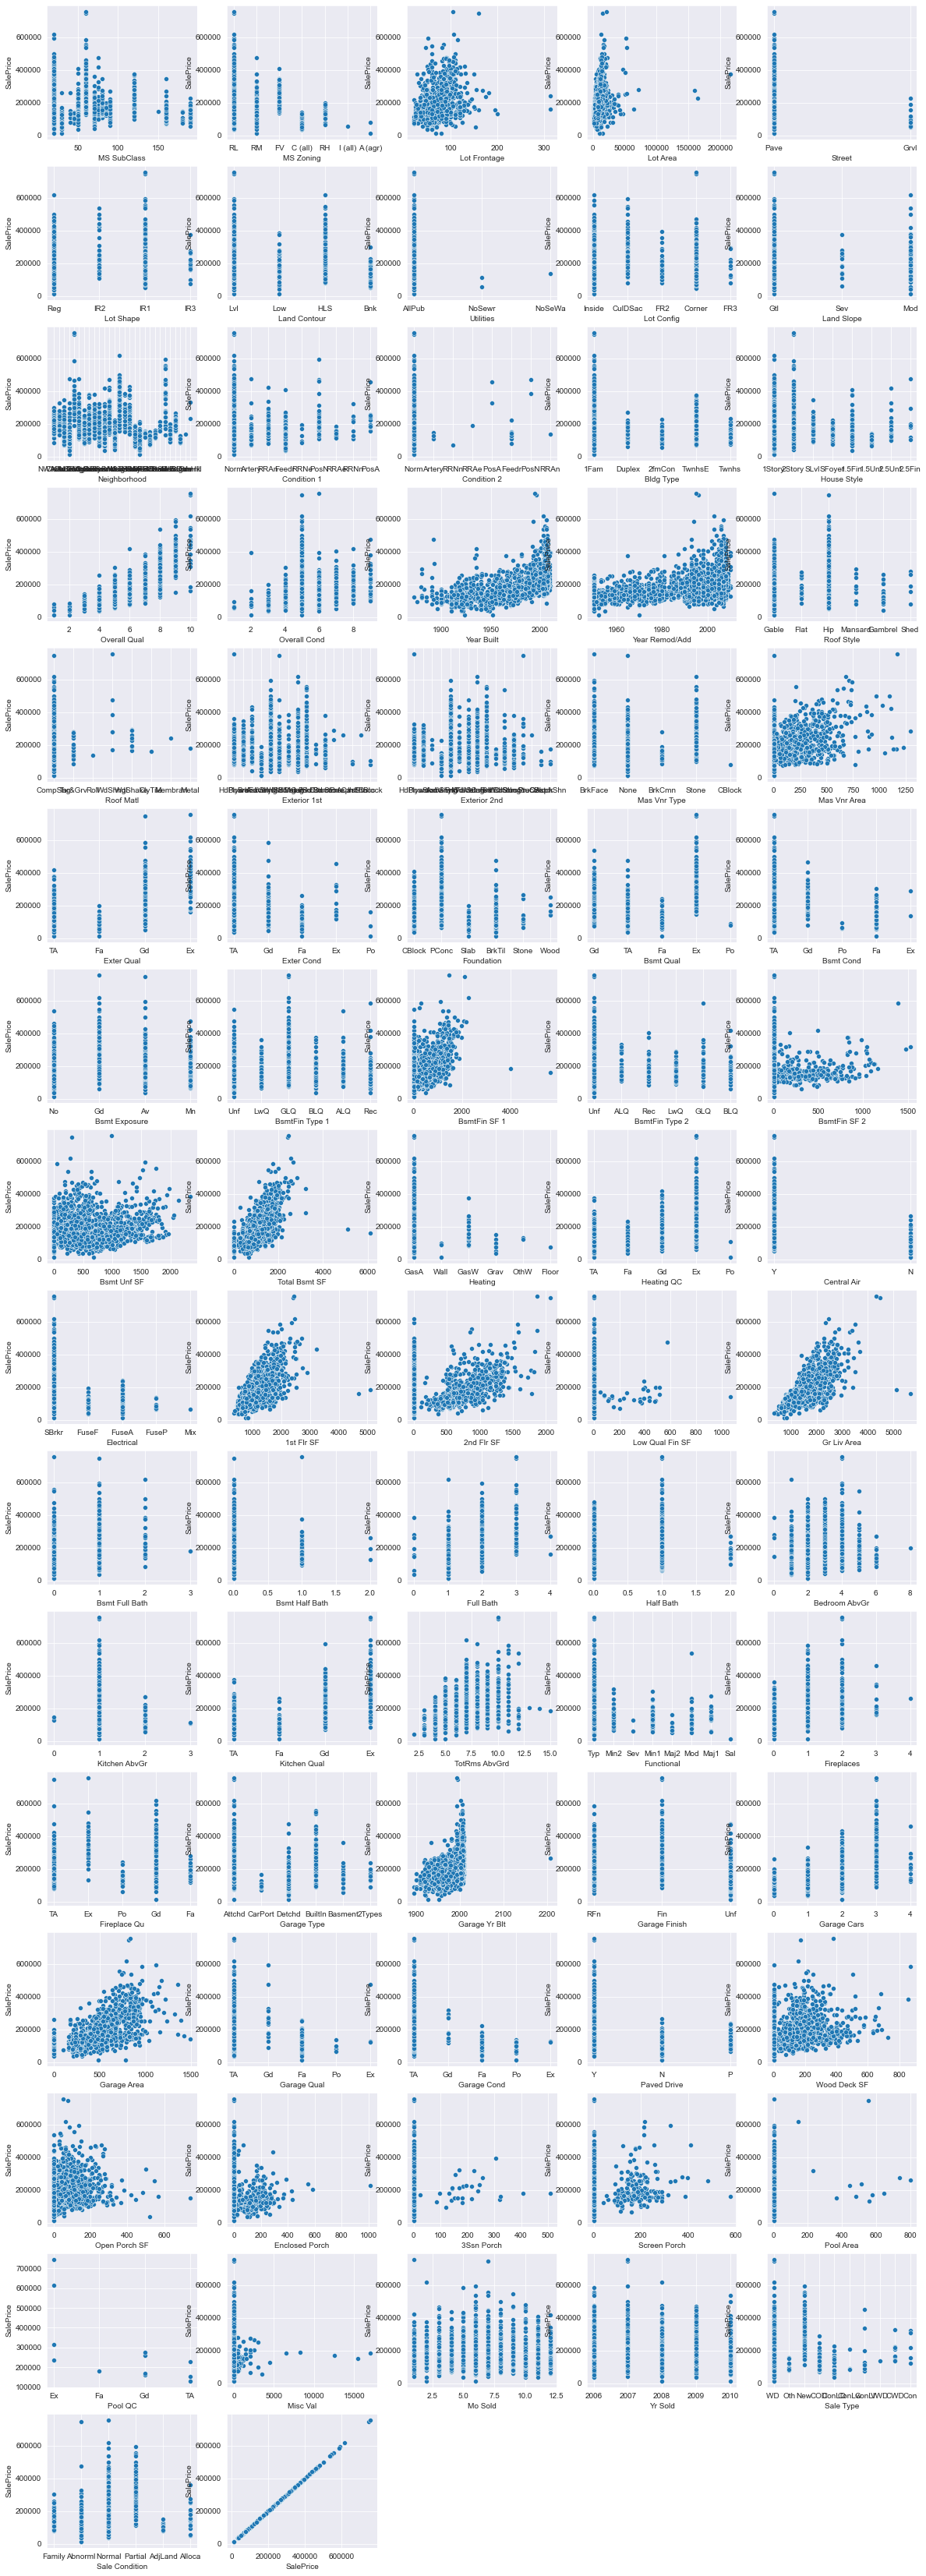

In [343]:
plt.figure(figsize=(20,60))
for i, col in enumerate(df_train.columns):
    ax = plt.subplot(math.ceil(len(df_train.columns) / 5), 5, i+1)
    sns.scatterplot(data=df_train, x=col, y=df_train["SalePrice"],ax=ax)

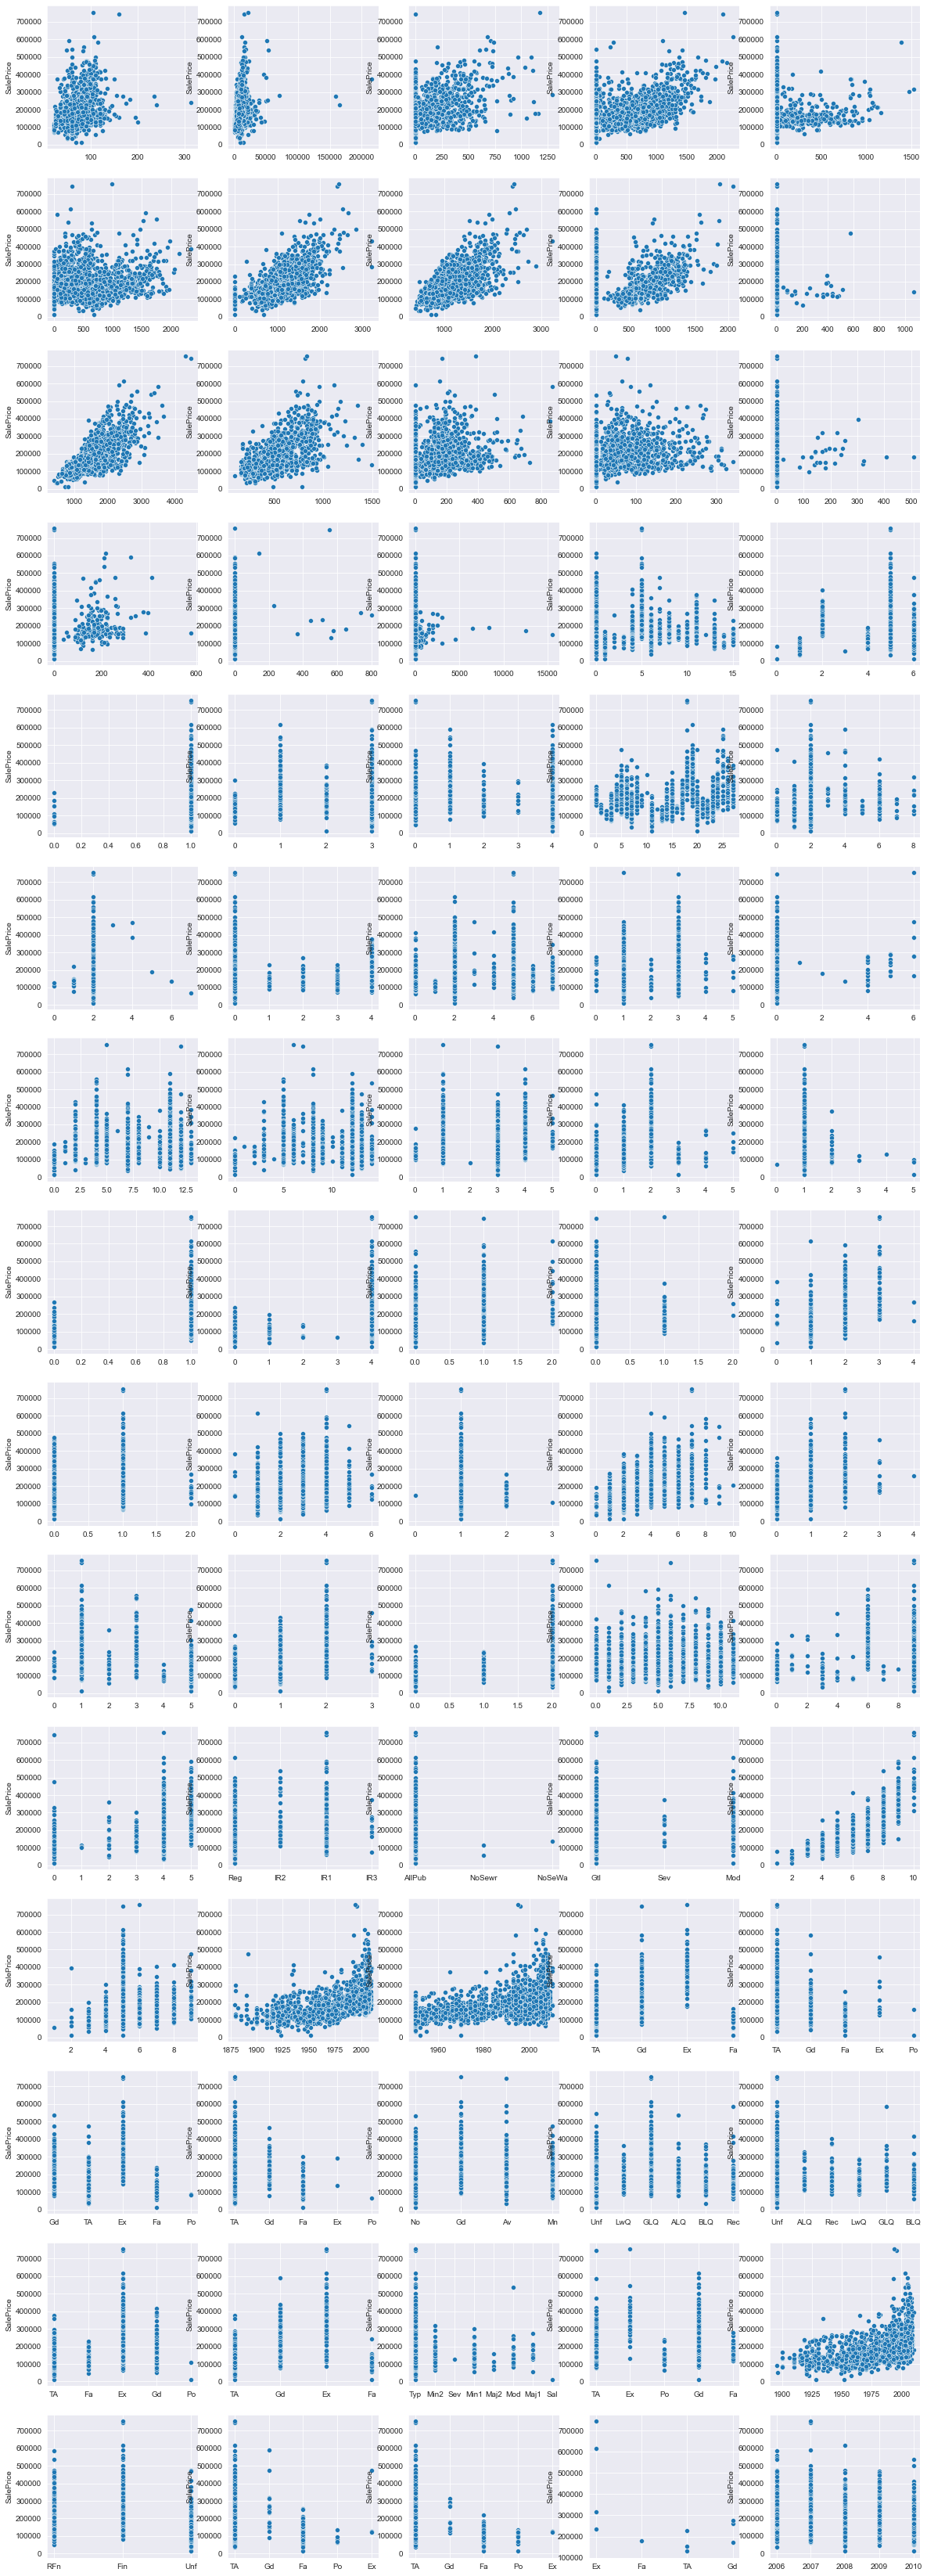

In [344]:
num = IterativeImputer()
cat = Pipeline([
    ("label", OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=np.nan)),
    ("imputer", IterativeImputer()),
    ("threshold", FunctionTransformer(np.round))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", num, numerical_features),
        ("cat", cat, categorical_features)
    ],
    remainder="passthrough"
)
test_data = preprocessor.fit_transform(X_train)

plt.figure(figsize=(20,60))
for i, col in enumerate(X_train.columns):
    ax = plt.subplot(math.ceil(len(X_train.columns) / 5), 5, i+1)
    sns.scatterplot(x=test_data[:, list(X_train.columns).index(col)], y=y_train, ax=ax)

### Create a "House Area" column

In [355]:
to_add = ["Total Bsmt SF", "1st Flr SF", "2nd Flr SF", "Garage Area", "Wood Deck SF", "Open Porch SF"]
df_train["House Area"] = 0
df_test["House Area"] = 0
for col in to_add:
    df_train["House Area"] += df_train[col].fillna(0)
    df_test["House Area"] += df_test[col].fillna(0)

In [347]:
numerical_features.append("House Area")

<AxesSubplot:xlabel='House Area', ylabel='SalePrice'>

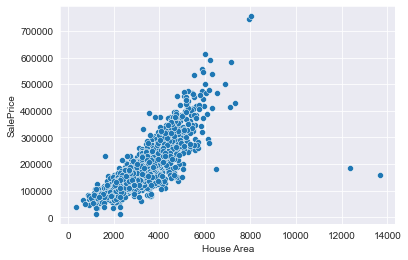

In [383]:
sns.scatterplot(data=df_train, x="House Area", y=df_train["SalePrice"])

In [356]:
numerical_transformer = SimpleImputer()
categorical_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

ordinal_encoding= ColumnTransformer(
    transformers=[
        ("other", OrdinalEncoder(categories=[
            ["Reg", "IR1", "IR2", "IR3"],
            ["ELO", "NoSeWa", "NoSewr", "AllPub"],
            ["Gtl", "Mod", "Sev"],
            [None, "No", "Mn", "Av", "Gd"],
            [None, "Unf", "LwQ", "Rec", "BLQ", "ALQ", "GLQ"],
            [None, "Unf", "LwQ", "Rec", "BLQ", "ALQ", "GLQ"],
            ["Sal", "Sev", "Maj2", "Maj1", "Mod", "Min2", "Min1", "Typ"],
            [None, "Unf", "RFn", "Fin"]
        ]), ["Lot Shape", "Utilities", "Land Slope", "Bsmt Exposure", 'BsmtFin Type 1', 'BsmtFin Type 2', "Functional", "Garage Finish"]),

        ("qual_cond_nan", OrdinalEncoder(categories=
        [["Po", None, "Fa", "TA", "Gd", "Ex"] for _ in range(6)]),
        ['Bsmt Qual', 'Bsmt Cond', 'Fireplace Qu', 'Garage Qual', 'Pool QC', 'Garage Cond']
        ),

        ("qual_cond", OrdinalEncoder(categories=
        [["Po", "Fa", "TA", "Gd", "Ex"] for _ in range(4)]),
        ['Exter Qual', 'Exter Cond', 'Heating QC', 'Kitchen Qual']),

    ],
    remainder="passthrough" # Overall Qual/Cond, 'Yr Sold', 'Garage Yr Blt', 'Year Built', 'Year Remod/Add'
)

ordinal_transformer = Pipeline([
    ("ord_encoding", ordinal_encoding),
    ("imputing", SimpleImputer())
])

In [362]:
X_train = df_train.drop(["SalePrice"], axis=1)
y_train = df_train["SalePrice"]

X_test = df_test.drop(["SalePrice"], axis=1)
y_test = df_test["SalePrice"]

In [358]:
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numerical_transformer, numerical_features),
        ("cat", categorical_transformer, categorical_features),
        ("ord", ordinal_transformer, ordinal_features)
    ],
    remainder="drop"
)

inference_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("model", LinearRegression())
])

inference_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', SimpleImputer(),
                                                  ['Lot Frontage', 'Lot Area',
                                                   'Mas Vnr Area',
                                                   'BsmtFin SF 1',
                                                   'BsmtFin SF 2',
                                                   'Bsmt Unf SF',
                                                   'Total Bsmt SF',
                                                   '1st Flr SF', '2nd Flr SF',
                                                   'Low Qual Fin SF',
                                                   'Gr Liv Area', 'Garage Area',
                                                   'Wood Deck SF',
                                                   'Open Porch SF',
                                                   '3Ssn Porch', 'Screen Porch',
                                                   'Pool Area', 'Misc Val',
                                                   'House Area']),
                                                 ('cat',
                                                  Pipeline(steps=[...
                                                                   SimpleImputer())]),
                                                  ['Lot Shape', 'Utilities',
                                                   'Land Slope', 'Overall Qual',
                                                   'Overall Cond', 'Exter Qual',
                                                   'Exter Cond', 'Bsmt Qual',
                                                   'Bsmt Cond', 'Bsmt Exposure',
                                                   'BsmtFin Type 1',
                                                   'BsmtFin Type 2',
                                                   'Heating QC', 'Kitchen Qual',
                                                   'Functional', 'Fireplace Qu',
                                                   'Garage Finish',
                                                   'Garage Qual', 'Garage Cond',
                                                   'Pool QC', 'Yr Sold',
                                                   'Garage Yr Blt',
                                                   'Year Built',
                                                   'Year Remod/Add'])])),
                ('model', LinearRegression())])

In [363]:
compare_to_base(*mae(inference_pipeline, X_train, y_train, X_test, y_test))

MAE on train data:  15652.044816353502
MAE on test data:  18241.08135623298
Difference with base train:  -4637.288098097388
Difference with base test:  -3083.8351377374347
